In [59]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd,numpy as np

import warnings
warnings.filterwarnings('ignore')

In [60]:
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",300)

# Importing dataset
telecom = pd.read_csv("telecom_churn_data.csv")
telecom.head()

# Let's check the dimensions of the dataframe
telecom.shape

(99999, 226)

In [61]:
##Stripping off white_spaces from the column name(if any)
telecom= telecom.rename(columns= lambda x: x.strip(), inplace=False)

## Incorrect name columns 
last_day_rech_cols = list(telecom.columns[telecom.columns.str.contains('last_day_rch_amt')])
last_day_rech_cols

##Correcting name of 'last_day_rch_amt_*' to 'last_day_rech_amt_*' columns (for months 6,7,8 and 9 respectively)
telecom= telecom.rename(columns= {'last_day_rch_amt_6':'last_day_rech_amt_6', 'last_day_rch_amt_7':'last_day_rech_amt_7',\
                                     'last_day_rch_amt_8':'last_day_rech_amt_8', 'last_day_rch_amt_9':'last_day_rech_amt_9'})
correct_last_day_rech_amt_col = list(telecom.columns[telecom.columns.str.contains('last_day')])
correct_last_day_rech_amt_col

# Creating a copy of the data incase it is required later
telecom_churn = telecom.copy()

In [62]:
# total amount of recharge for talktime we dont have that number for data, instead we have average and number of rechanrges
telecom_churn['total_data_rech_amt_6'] = telecom_churn['av_rech_amt_data_6'] * telecom_churn['total_rech_data_6']
telecom_churn['total_data_rech_amt_7'] = telecom_churn['av_rech_amt_data_7'] * telecom_churn['total_rech_data_7']
telecom_churn['total_data_rech_amt_8'] = telecom_churn['av_rech_amt_data_8'] * telecom_churn['total_rech_data_8']
telecom_churn['total_data_rech_amt_9'] = telecom_churn['av_rech_amt_data_9'] * telecom_churn['total_rech_data_9']

In [63]:
# Drop the columns already accounted for 
telecom_churn.drop(['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9', 'av_rech_amt_data_6',
              'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9'], axis=1, inplace=True)

# calculating average recharge done by customer in 6th and 7th month i.e for good phase 
avg_total_rech_amt_gd_phase = ( telecom_churn['total_rech_amt_6'].fillna(0) + telecom_churn['total_rech_amt_7'].fillna(0) + 
                               telecom_churn['total_data_rech_amt_6'].fillna(0) + telecom_churn['total_data_rech_amt_7'].fillna(0) ) / 2

# looking 70 percentile of the avg_total_rech_amt_gd_phase
avg_total_rech_amt_gd_phase_filter = np.percentile(avg_total_rech_amt_gd_phase, 70.0)
print(avg_total_rech_amt_gd_phase_filter)

# high value customer data
telecom_churn =  telecom_churn[avg_total_rech_amt_gd_phase >= avg_total_rech_amt_gd_phase_filter]
telecom_churn.shape

478.0


(30001, 222)

#### Observation: 
On filtering the high-value customers, we get about 30K observations. These shall be used for further analysis.

#### Deriving Churn column :
Now tagging the churned customers (churn=1, else 0) based on the 9th month(i.e september) as follows: Those who have not made any calls (either incoming or outgoing) and have not used mobile internet even once in the churn phase.

In [64]:
telecom_churn["churn"] = np.where((telecom_churn["total_ic_mou_9"]==0) & (telecom_churn["total_og_mou_9"]==0) & (telecom_churn["vol_2g_mb_9"]==0) & (telecom_churn["vol_3g_mb_9"]==0), 1, 0)
telecom_churn.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rech_amt_6,last_day_rech_amt_7,last_day_rech_amt_8,last_day_rech_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_data_rech_amt_6,total_data_rech_amt_7,total_data_rech_amt_8,total_data_rech_amt_9,churn
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,4,3,2,6,362,252,252,0,252,252,252,0,6/21/2014,7/16/

In [65]:
# Deleting all the attributes corresponding to the churn phase i.e 9 months

churn_phase_9 = [col for col in telecom_churn.columns.to_list() if '_9' in col]
print(churn_phase_9)

# Deleting the churn phase columns
telecom_churn = telecom_churn.drop(churn_phase_9, axis=1)

# Dropping sep_vbc_3g column
telecom_churn =telecom_churn.drop('sep_vbc_3g', axis=1)
telecom_churn.shape

['last_date_of_month_9', 'arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9', 'std_og_t2t_mou_9', 'std_og_t2m_mou_9', 'std_og_t2f_mou_9', 'std_og_t2c_mou_9', 'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9', 'std_ic_t2o_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'total_rech_amt_9', 'max_rech_amt_9', 'date_of_last_rech_9', 'last_day_rech_amt_9', 'date_of_last_rech_data_9', 'max_rech_data_9', 'count_rech_2g_9', 'count_rech_3g_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'arpu_3g_9', 'arpu_2g_9', 'night_pck_user_9', 'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9', 'fb_user_9', 'total_data_rech_amt_9']


(30001, 169)

### Data Preparation (Data Cleaning and Treatment)

In [66]:
# Mising Data Percentage 
telecom_missing_col = telecom_churn.isnull().sum()*100/telecom_churn.shape[0]
telecom_missing_col

# Select columns with more than 40% missing values
missing_val_col =telecom_missing_col[telecom_missing_col > 40].index.tolist()
missing_val_col

# Drop missing_val_col > 40% missing values
telecom_churn.drop(missing_val_col, axis=1, inplace=True)
telecom_churn.shape

telecom_churn.isnull().sum()*100/telecom_churn.shape[0]

mobile_number           0.000000
circle_id               0.000000
loc_og_t2o_mou          0.746642
std_og_t2o_mou          0.746642
loc_ic_t2o_mou          0.746642
last_date_of_month_6    0.000000
last_date_of_month_7    0.089997
last_date_of_month_8    0.549982
arpu_6                  0.000000
arpu_7                  0.000000
arpu_8                  0.000000
onnet_mou_6             1.816606
onnet_mou_7             1.789940
onnet_mou_8             3.913203
offnet_mou_6            1.816606
offnet_mou_7            1.789940
offnet_mou_8            3.913203
roam_ic_mou_6           1.816606
roam_ic_mou_7           1.789940
roam_ic_mou_8           3.913203
roam_og_mou_6           1.816606
roam_og_mou_7           1.789940
roam_og_mou_8           3.913203
loc_og_t2t_mou_6        1.816606
loc_og_t2t_mou_7        1.789940
loc_og_t2t_mou_8        3.913203
loc_og_t2m_mou_6        1.816606
loc_og_t2m_mou_7        1.789940
loc_og_t2m_mou_8        3.913203
loc_og_t2f_mou_6        1.816606
loc_og_t2f

In [67]:
# remaining colums have less than 5% of the data missing we can drop the rows with the missing values.
for col in telecom_churn.columns:
    telecom_churn = telecom_churn[~telecom_churn[col].isna()]
telecom_churn.isnull().sum()*100/telecom_churn.shape[0]

mobile_number           0.0
circle_id               0.0
loc_og_t2o_mou          0.0
std_og_t2o_mou          0.0
loc_ic_t2o_mou          0.0
last_date_of_month_6    0.0
last_date_of_month_7    0.0
last_date_of_month_8    0.0
arpu_6                  0.0
arpu_7                  0.0
arpu_8                  0.0
onnet_mou_6             0.0
onnet_mou_7             0.0
onnet_mou_8             0.0
offnet_mou_6            0.0
offnet_mou_7            0.0
offnet_mou_8            0.0
roam_ic_mou_6           0.0
roam_ic_mou_7           0.0
roam_ic_mou_8           0.0
roam_og_mou_6           0.0
roam_og_mou_7           0.0
roam_og_mou_8           0.0
loc_og_t2t_mou_6        0.0
loc_og_t2t_mou_7        0.0
loc_og_t2t_mou_8        0.0
loc_og_t2m_mou_6        0.0
loc_og_t2m_mou_7        0.0
loc_og_t2m_mou_8        0.0
loc_og_t2f_mou_6        0.0
loc_og_t2f_mou_7        0.0
loc_og_t2f_mou_8        0.0
loc_og_t2c_mou_6        0.0
loc_og_t2c_mou_7        0.0
loc_og_t2c_mou_8        0.0
loc_og_mou_6        

In [68]:
# we eliminating date columns as they won't be useful for our analysis
date_columns = list(telecom_churn.columns[telecom_churn.columns.str.contains("date")])
date_columns

['last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8']

In [69]:
# Dropping the date columns
telecom_churn.drop(date_columns, axis=1, inplace=True)
unique_val = []

for col in telecom_churn.columns:
    if telecom_churn[col].nunique() == 1:
        unique_val.append(col)
unique_val

# Dropping unique value columns
telecom_churn.drop(unique_val, axis=1, inplace=True)
telecom_churn.shape


(28163, 126)

In [70]:
##Creating  a new column tenure_year to store the number of years the customer has been on network T
telecom_churn['tenure_yr'] = round(telecom_churn['aon']/365, 1)

print(telecom_churn.tenure_yr.value_counts())
print("Min:",telecom_churn.tenure_yr.min())
print("Max:",telecom_churn.tenure_yr.max())

1.3     1281
0.8      974
0.6      966
1.0      939
1.4      911
0.9      910
0.7      839
1.2      764
1.1      700
1.7      640
2.0      639
1.8      629
1.5      609
1.9      574
0.5      562
2.2      488
1.6      484
2.1      476
2.3      474
10.0     469
2.4      453
2.6      431
3.0      396
2.8      396
2.9      383
2.5      376
2.7      349
6.5      333
3.1      328
3.3      319
3.2      299
3.4      288
3.6      287
8.5      281
3.5      281
3.7      278
3.8      270
4.2      239
3.9      236
4.0      229
4.6      225
6.6      213
7.1      207
6.9      207
4.3      197
4.7      197
7.0      195
6.8      194
7.6      189
4.1      182
7.5      177
7.9      171
6.4      167
4.9      167
7.8      164
4.4      160
6.7      160
7.2      157
5.4      155
7.4      154
8.0      153
6.3      151
6.2      146
4.5      141
8.8      138
5.0      138
4.8      137
7.7      136
6.1      134
8.1      133
5.5      133
8.2      127
5.3      127
8.4      124
8.3      124
5.6      121
7.3      119

In [71]:
##Creating bins
bins_yr = [0,1,2,3,5,12]
label_aon= ['0_1_yr','1_2_yr','2_3_yr','3_5_yr','5_12_yr']
telecom_churn['tenure'] = pd.cut(telecom_churn['tenure_yr'], bins= bins_yr, labels= label_aon)

In [72]:
##Dropping 'tenure_yr' and 'aon' column as we have already created bins in 'tenure' column
telecom_churn.drop(['tenure_yr','aon'] , axis=1, inplace= True)

telecom_churn.tenure.value_counts()

# Dropping the column 'mobile_number' as it will not useful in analysis 
telecom_churn.drop("mobile_number", axis=1, inplace=True)
telecom_churn.head()


,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rech_amt_6,last_day_rech_amt_7,last_day_rech_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn,tenure
7,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.0,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,60.86,75.14,77.84,0.0,0.18,10.01,4.5,0.0,6.50,0.0,0.0,0.0,487.53,609.24,350.16,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,427.88,355.23,188.04,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,180.54,173.08,193.94,626.46,558.04,428.74,0.21,0.0,0.0,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,0,0,779,0.00,0.00,0.00,0.0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,57.74,19.38,18.74,1,2_3_yr
8,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.0,0.0,7.15,378.09,288.18,63.04,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,130.26,143.48,98.28,0.0,0.00,0.00,0.0,0.0,10.23,0.0,0.0,0.0,508.36,431.66,171.56,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,81.43,23.83,15.79,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,22.43,4.66,0.75,103.86,28.49,16.54,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,19,21,14,437,601,120,90,154,30,50,0,10,0.00,356.00,0.03,0.0,750.95,11.94,0,1,0,0,1,3,0,0,0,0,0,0,21.03,910.65,122.16,0,0_1_yr
21,514.453,597.753,637.760,102.41,132.11,85.14,757.93,896.68,983.39,0.00,0.00,0.00,0.00,0.00,0.00,4.48,6.16,23.34,91.81,87.93,104.81,0.75,0.00,1.58,0.0,0.0,0.00,97.04,94.09,129.74,97.93,125.94,61.79,665.36,808.74,876.99,0.00,0.00,0.00,763.29,934.69,938.79,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,860.34,1028.79,1068.54,2.48,10.19,19.54,118.23,74.63,129.16,4.61,2.84,10.39,125.33,87.68,159.11,14.06,5.98,0.18,67.69,38.23,101.74,0.00,0.00,0.00,81.76,44.21,101.93,207.09,131.89,261.04,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,22,26,27,600,680,718,50,50,50,30,20,50,0.00,0.00,0.00,0.0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0,1_2_yr
23,74.350,193.897,366.966,48.96,50.66,33.58,85.41,89.36,205.89,0.00,0.00,0.00,0.00,0.00,0.00,48.96,50.66,33.58,82.94,83.01,148.56,0.00,0.00,0.00,0.0,0.0,17.71,131.91,133.68,182.14,0.00,0.00,0.00,2.36,6.35,39.61,0.00,0.00,0.00,2.36,6.35,39.61,0.0,0.01,0.00,0.1,0

In [73]:

# Creating new feature and drop the redundant columns
col_6_7 = [col[:-2] for col in telecom_churn.columns if '6' in col or '7' in col]
for col in set(col_6_7):
    telecom_churn[f'gd_ph_{col}'] = (  telecom_churn[f'{col}_6'] +  telecom_churn[f'{col}_7'] ) / 2
    telecom_churn.drop([f'{col}_6', f'{col}_7'], axis=1, inplace=True)
        
##Continuous features
cont_cols= [i for i in telecom_churn.columns if i not in ['mobile_number', 'churn', 'tenure']]
cont_cols

['arpu_8',
 'onnet_mou_8',
 'offnet_mou_8',
 'roam_ic_mou_8',
 'roam_og_mou_8',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_8',
 'loc_og_mou_8',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_8',
 'std_og_mou_8',
 'isd_og_mou_8',
 'spl_og_mou_8',
 'og_others_8',
 'total_og_mou_8',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_8',
 'loc_ic_t2f_mou_8',
 'loc_ic_mou_8',
 'std_ic_t2t_mou_8',
 'std_ic_t2m_mou_8',
 'std_ic_t2f_mou_8',
 'std_ic_mou_8',
 'total_ic_mou_8',
 'spl_ic_mou_8',
 'isd_ic_mou_8',
 'ic_others_8',
 'total_rech_num_8',
 'total_rech_amt_8',
 'max_rech_amt_8',
 'last_day_rech_amt_8',
 'vol_2g_mb_8',
 'vol_3g_mb_8',
 'monthly_2g_8',
 'sachet_2g_8',
 'monthly_3g_8',
 'sachet_3g_8',
 'aug_vbc_3g',
 'jul_vbc_3g',
 'jun_vbc_3g',
 'gd_ph_std_og_t2t_mou',
 'gd_ph_std_ic_mou',
 'gd_ph_last_day_rech_amt',
 'gd_ph_monthly_3g',
 'gd_ph_sachet_3g',
 'gd_ph_max_rech_amt',
 'gd_ph_roam_ic_mou',
 'gd_ph_spl_og_mou',
 'gd_ph_vol_3g_mb',
 'gd_ph_std_

In [74]:
telecom_churn.describe(percentiles= [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999])

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,total_og_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,loc_ic_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,std_ic_mou_8,total_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rech_amt_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn,gd_ph_std_og_t2t_mou,gd_ph_std_ic_mou,gd_ph_last_day_rech_amt,gd_ph_monthly_3g,gd_ph_sachet_3g,gd_ph_max_rech_amt,gd_ph_roam_ic_mou,gd_ph_spl_og_mou,gd_ph_vol_3g_mb,gd_ph_std_og_t2f_mou,gd_ph_offnet_mou,gd_ph_total_ic_mou,gd_ph_loc_ic_t2t_mou,gd_ph_loc_ic_t2m_mou,gd_ph_std_og_t2m_mou,gd_ph_sachet_2g,gd_ph_loc_og_mou,gd_ph_std_ic_t2m_mou,gd_ph_monthly_2g,gd_ph_loc_ic_t2f_mou,gd_ph_vol_2g_mb,gd_ph_isd_og_mou,gd_ph_loc_og_t2m_mou,gd_ph_ic_others,gd_ph_og_others,gd_ph_loc_ic_mou,gd_ph_loc_og_t2f_mou,gd_ph_total_rech_amt,gd_ph_std_ic_t2f_mou,gd_ph_isd_ic_mou,gd_ph_loc_og_t2c_mou,gd_ph_loc_og_t2t_mou,gd_ph_total_rech_num,gd_ph_std_ic_t2t_mou,gd_ph_onnet_mou,gd_ph_arpu,gd_ph_roam_og_mou,gd_ph_spl_ic_mou,gd_ph_total_og_mou,gd_ph_std_og_mou
count,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000
mean,528.992500,246.288657,351.089623,13.145865,20.926258,82.376724,159.312714,6.147877,1.789363,247.845569,155.918660,164.553111,1.646062,322.121339,1.989213,6.889342,0.061151,578.914527,66.142275,154.295671,15.191563,235.639315,14.625113,29.440255,2.692254,46.761176,295.165236,0.027889,11.437856,1.291328,10.435323,610.754607,164.597131,94.779640,109.831129,349.209687,0.160210,1.100771,0.209459,0.208287,173.745705,180.655113,157.965702,0.054611,173.644175,49.261396,98.522885,0.213773,0.217200,167.748198,14.632102,6.610121,344.784010,1.840391,384.886852,303.171601,68.446871,156.297192,187.079217,1.154618,263.016895,30.886979,0.183397,16.277503,127.717157,2.047679,168.146426,1.371220,0.359434,241.031533,6.572665,668.439602,2.835280,11.458002,1.766261,88.289263,12.026489,15.535415,271.207259,567.163074,23.757457,0.041413,634.610425,362.567597
std,500.479643,465.372774,482.498518,76.125433,107.722393,233.412303,235.001352,19.904718,7.390599,367.353912,404.045802,413.804895,11.126142,615.275135,45.888765,20.813297,3.421503,699.739896,163.115483,218.559404,44.457495,313.175366,73.017056,106.285136,20.476161,142.430462,366.056859,0.113430,72.276371,13.164084,9.288002,610.396698,169.014286,141.789453,317.809110,886.448371,0.413067,2.573361,0.619138,1.116503,424.621028,447.089836,415.879933,0.227223,388.535547,135.463961,108.064480,0.565446,0.940707,148.011960,66.404361,17.610173,790.524029,11.647474,458.317317,353.512953,159.772390,208.585177,397.127914,2.435548,361.575126,94.977327,0.392058,45.347936,304.044111,45.5364

In [75]:
# Removing outliersin between 1 and 99.9 percentiles
for col in cont_cols: 
    q1 = telecom_churn[col].quantile(0.010)
    q3 = telecom_churn[col].quantile(0.999)
    iqr = q3-q1
    range_lower  = q1-1.5*iqr
    range_upper = q3+1.5*iqr
    
    # Assigning the filtered dataset into data
    tele_churn_data_1 = telecom_churn.loc[(telecom_churn[col] > range_lower) & (telecom_churn[col] < range_upper)]
 
tele_churn_data_1.shape

(28163, 85)

### Step 4: EDA
### Univariant Analysis:
#### Deriving new column decrease_rech_num_actionphase
Churn rate on the basis whether the customer decreased consumers number of recharge in action month. This column indicates whether the number of recharge of the customer has decreased in the action phase than the good phase

In [76]:
# Difference total_rech_num_8 and gd_ph_total_rech_num
tele_churn_data_1['diff_rech_num'] =tele_churn_data_1['total_rech_num_8']- tele_churn_data_1['gd_ph_total_rech_num'] 

# Checking if rech_num has decreased in action phase
tele_churn_data_1['decrease_rech_num_actionphase'] = np.where((tele_churn_data_1['diff_rech_num'] < 0), 1, 0)

tele_churn_data_1.head()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,total_og_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,loc_ic_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,std_ic_mou_8,total_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rech_amt_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn,tenure,gd_ph_std_og_t2t_mou,gd_ph_std_ic_mou,gd_ph_last_day_rech_amt,gd_ph_monthly_3g,gd_ph_sachet_3g,gd_ph_max_rech_amt,gd_ph_roam_ic_mou,gd_ph_spl_og_mou,gd_ph_vol_3g_mb,gd_ph_std_og_t2f_mou,gd_ph_offnet_mou,gd_ph_total_ic_mou,gd_ph_loc_ic_t2t_mou,gd_ph_loc_ic_t2m_mou,gd_ph_std_og_t2m_mou,gd_ph_sachet_2g,gd_ph_loc_og_mou,gd_ph_std_ic_t2m_mou,gd_ph_monthly_2g,gd_ph_loc_ic_t2f_mou,gd_ph_vol_2g_mb,gd_ph_isd_og_mou,gd_ph_loc_og_t2m_mou,gd_ph_ic_others,gd_ph_og_others,gd_ph_loc_ic_mou,gd_ph_loc_og_t2f_mou,gd_ph_total_rech_amt,gd_ph_std_ic_t2f_mou,gd_ph_isd_ic_mou,gd_ph_loc_og_t2c_mou,gd_ph_loc_og_t2t_mou,gd_ph_total_rech_num,gd_ph_std_ic_t2t_mou,gd_ph_onnet_mou,gd_ph_arpu,gd_ph_roam_og_mou,gd_ph_spl_ic_mou,gd_ph_total_og_mou,gd_ph_std_og_mou,diff_rech_num,decrease_rech_num_actionphase
7,3171.480,52.29,325.91,31.64,38.06,40.28,162.28,53.23,0.00,255.79,12.01,49.14,16.68,77.84,10.01,6.50,0.0,350.16,27.31,121.19,39.53,188.04,30.39,141.33,22.21,193.94,428.74,0.0,31.59,15.14,7,3638,1580,779,0.00,0.00,0,0,0,0,57.74,19.38,18.74,1,2_3_yr,13.795,176.810,0.0,0.0,0.0,1185.0,24.86,2.25,0.000,13.37,510.295,592.250,45.200,219.525,40.825,0.0,478.035,109.215,0.0,126.810,0.000,0.090,378.005,15.465,0.0,391.555,58.635,1185.0,43.215,8.295,0.0,41.385,5.0,24.360,56.26,1209.5150,18.165,0.105,548.385,68.000,2.0,0
8,137.362,35.08,136.48,0.00,0.00,12.49,50.54,0.00,7.15,63.04,22.58,75.69,0.00,98.28,0.00,10.23,0.0,171.56,0.31,15.48,0.00,15.79,0.10,0.65,0.00,0.75,16.54,0.0,0.00,0.00,14,120,30,10,0.03,11.94,0,3,0,0,21.03,910.65,122.16,0,0_1_yr,124.995,13.545,25.0,0.0,0.0,122.0,0.00,0.00,375.475,0.00,87.645,66.175,16.840,35.780,11.865,0.5,333.135,13.255,0.5,0.000,178.000,0.000,75.770,0.000,0.0,52.630,0.000,519.0,0.000,0.000,0.0,257.360,20.0,0.290,382.36,435.4720,0.000,0.000,470.010,136.870,-6.0,1
21,637.760,85.14,983.39,0.00,0.00,23.34,104.81,1.58,0.00,129.74,61.79,876.99,0.00,938.79,0.00,0.00,0.0,1068.54,19.54,129.16,10.39,159.11,0.18,101.74,0.00,101.93,261.04,0.0,0.00,0.00,27,718,50,50,0.00,0.00,0,0,0,0,0.00,0.00,0.00,0,1_2_yr,111.935,62.985,25.0,0.0,0.0,50.0,0.00,0.00,0.000,0.00,827.305,169.490,6.335,96.430,737.050,0.0,95.565,52.960,0.0,3.725,0.000,0.000,89.870,0.000,0.0,106.505,0.375,640.0,0.000,0.000,0.0,5.320,24.0,10.020,117.26,556.1030,0.000,0.000,944.565,848.990,3.0,0
23,366.966,33.58,205.89,0.00,0.00,33.58,148.56,0.00,17.71,182.14,0.00,39.61,0.00,39.61,0.00,17.71,0.0,239.48,76.64,146.84,0.71,224.21,13.38,43.91,0.00,57.29,298.33,0.0,3.74,13.06,4,439,179,0,0.01,1009.92,0,0,1,1,40.45,51.86,0.00,0,1_2_yr,0.000,8.915,89.5,1.0,0.0,89.5,0.00,0.05,299.545,0.00,87.385,171.235,40.875,104.635,4.355,0.0,132.795,8.660,0.0,0.000,0.240,0.005,82.975,2.675,0.0,145.520,0.000,227.0,0.000,14.115,0.0,49.810,4.0,0.255,49.81,134.1235,0.000,0.000,137.210,4.355,0.0,0
33,409.230,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.56,0.00,0.00,0.00,0.00,0.00,0.00,0.56,0.0,0.56,2.45,37.93,0.16,40.54,0.05,0.86,0.13,1.04,41.79,0.0,0.00,0.20,1,455,455,455,7.97,7701.01,0,0,1,0,358.10,2706.83,1714.67,0,3_5_yr,0.000,4.420,126.0,4.5,2.0,753.5,0.00,0.00,5832.275,0.00,0.000,7.540,1.155,0.000,0.000,0.0,0.000,2.365,0.0,1.020,72.405,0.000,0.000,0.940,0.0,2.180,0.000,1932.0,0.595,0.000,0.0,0.000,10.5,1.455,0.00,1669.9265,0.000,0.000,0.000,0.000,-9.5,1


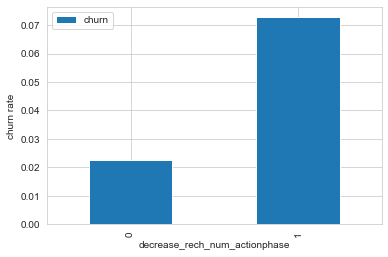

In [77]:
# Converting churn column to int in order to do aggfunc in the pivot table
tele_churn_data_1['churn'] = tele_churn_data_1['churn'].astype('int64')

tele_churn_data_1.pivot_table(values='churn', index='decrease_rech_num_actionphase', aggfunc="mean").plot.bar()
plt.ylabel('churn rate')
plt.show()

#### Observation:
The churn rate is more for the customers, whose number of recharge in the action phase is lesser than the  in good phase.

#### Deriving new column decrease_vbc_action for 3G
This column indicates whether the volume based cost (VBC)of the customer has decreased in the action phase than the good phase.


In [78]:
# VBC in action phase
tele_churn_data_1['gd_ph_vbc_3g'] = (tele_churn_data_1['jun_vbc_3g'] + tele_churn_data_1['jul_vbc_3g'])/2

# Difference of good and action phase VBC
tele_churn_data_1['diff_vbc'] = tele_churn_data_1['aug_vbc_3g']-tele_churn_data_1['gd_ph_vbc_3g'] 

# Churn rate on the basis whether the customer decreased her/his volume based cost(vbc) in action month
tele_churn_data_1['decrease_vbc_actionphase'] = np.where(tele_churn_data_1['diff_vbc'] < 0 , 1, 0)
tele_churn_data_1.head()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,total_og_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,loc_ic_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,std_ic_mou_8,total_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rech_amt_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn,tenure,gd_ph_std_og_t2t_mou,gd_ph_std_ic_mou,gd_ph_last_day_rech_amt,gd_ph_monthly_3g,gd_ph_sachet_3g,gd_ph_max_rech_amt,gd_ph_roam_ic_mou,gd_ph_spl_og_mou,gd_ph_vol_3g_mb,gd_ph_std_og_t2f_mou,gd_ph_offnet_mou,gd_ph_total_ic_mou,gd_ph_loc_ic_t2t_mou,gd_ph_loc_ic_t2m_mou,gd_ph_std_og_t2m_mou,gd_ph_sachet_2g,gd_ph_loc_og_mou,gd_ph_std_ic_t2m_mou,gd_ph_monthly_2g,gd_ph_loc_ic_t2f_mou,gd_ph_vol_2g_mb,gd_ph_isd_og_mou,gd_ph_loc_og_t2m_mou,gd_ph_ic_others,gd_ph_og_others,gd_ph_loc_ic_mou,gd_ph_loc_og_t2f_mou,gd_ph_total_rech_amt,gd_ph_std_ic_t2f_mou,gd_ph_isd_ic_mou,gd_ph_loc_og_t2c_mou,gd_ph_loc_og_t2t_mou,gd_ph_total_rech_num,gd_ph_std_ic_t2t_mou,gd_ph_onnet_mou,gd_ph_arpu,gd_ph_roam_og_mou,gd_ph_spl_ic_mou,gd_ph_total_og_mou,gd_ph_std_og_mou,diff_rech_num,decrease_rech_num_actionphase,gd_ph_vbc_3g,diff_vbc,decrease_vbc_actionphase
7,3171.480,52.29,325.91,31.64,38.06,40.28,162.28,53.23,0.00,255.79,12.01,49.14,16.68,77.84,10.01,6.50,0.0,350.16,27.31,121.19,39.53,188.04,30.39,141.33,22.21,193.94,428.74,0.0,31.59,15.14,7,3638,1580,779,0.00,0.00,0,0,0,0,57.74,19.38,18.74,1,2_3_yr,13.795,176.810,0.0,0.0,0.0,1185.0,24.86,2.25,0.000,13.37,510.295,592.250,45.200,219.525,40.825,0.0,478.035,109.215,0.0,126.810,0.000,0.090,378.005,15.465,0.0,391.555,58.635,1185.0,43.215,8.295,0.0,41.385,5.0,24.360,56.26,1209.5150,18.165,0.105,548.385,68.000,2.0,0,19.060,38.680,0
8,137.362,35.08,136.48,0.00,0.00,12.49,50.54,0.00,7.15,63.04,22.58,75.69,0.00,98.28,0.00,10.23,0.0,171.56,0.31,15.48,0.00,15.79,0.10,0.65,0.00,0.75,16.54,0.0,0.00,0.00,14,120,30,10,0.03,11.94,0,3,0,0,21.03,910.65,122.16,0,0_1_yr,124.995,13.545,25.0,0.0,0.0,122.0,0.00,0.00,375.475,0.00,87.645,66.175,16.840,35.780,11.865,0.5,333.135,13.255,0.5,0.000,178.000,0.000,75.770,0.000,0.0,52.630,0.000,519.0,0.000,0.000,0.0,257.360,20.0,0.290,382.36,435.4720,0.000,0.000,470.010,136.870,-6.0,1,516.405,-495.375,1
21,637.760,85.14,983.39,0.00,0.00,23.34,104.81,1.58,0.00,129.74,61.79,876.99,0.00,938.79,0.00,0.00,0.0,1068.54,19.54,129.16,10.39,159.11,0.18,101.74,0.00,101.93,261.04,0.0,0.00,0.00,27,718,50,50,0.00,0.00,0,0,0,0,0.00,0.00,0.00,0,1_2_yr,111.935,62.985,25.0,0.0,0.0,50.0,0.00,0.00,0.000,0.00,827.305,169.490,6.335,96.430,737.050,0.0,95.565,52.960,0.0,3.725,0.000,0.000,89.870,0.000,0.0,106.505,0.375,640.0,0.000,0.000,0.0,5.320,24.0,10.020,117.26,556.1030,0.000,0.000,944.565,848.990,3.0,0,0.000,0.000,0
23,366.966,33.58,205.89,0.00,0.00,33.58,148.56,0.00,17.71,182.14,0.00,39.61,0.00,39.61,0.00,17.71,0.0,239.48,76.64,146.84,0.71,224.21,13.38,43.91,0.00,57.29,298.33,0.0,3.74,13.06,4,439,179,0,0.01,1009.92,0,0,1,1,40.45,51.86,0.00,0,1_2_yr,0.000,8.915,89.5,1.0,0.0,89.5,0.00,0.05,299.545,0.00,87.385,171.235,40.875,104.635,4.355,0.0,132.795,8.660,0.0,0.000,0.240,0.005,82.975,2.675,0.0,145.520,0.000,227.0,0.000,14.115,0.0,49.810,4.0,0.255,49.81,134.1235,0.000,0.000,137.210,4.355,0.0,0,25.930,14.520,0
33,409.230,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.56,0.00,0.00,0.00,0.00,0.00,0.00,0.56,0.0,0.56,2.45,37.93,0.16,40.54,0.05,0.86,0.13,1.04,41.79,0.0,0.00,0.20,1,455,455,455,7.97,7701.01,0,0,1,0,358.10,2706.83,1714.67,0,3_5_yr,0.000,4.420,126.0,4.5,2.0,753.5,0.00,0.00,5832.275,0.00,0.000,7.540,1.155,0.000,0.000,0.0,0.000,2.365,0.0,1.020,72.405,0.000,0.000,0.940,0.0,2.180,0.000,1932.0,0.595,0.000,0.0,0.000,10.5,1.455,0.00,1669.9265,0.000,0.000,0.000,0.000,-9.5,1,2210.750,-1852.650,1


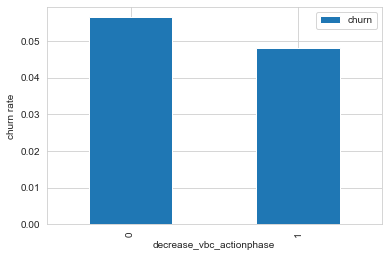

In [79]:
tele_churn_data_1.pivot_table(values='churn', index='decrease_vbc_actionphase', aggfunc='mean').plot.bar()
plt.ylabel('churn rate')
plt.show()

#### Observation:
Churn rate is more for the customer whos volume based cost for 3G dropped in action phase. 

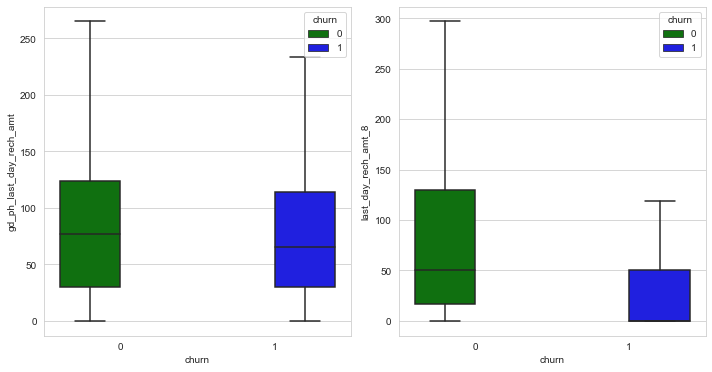

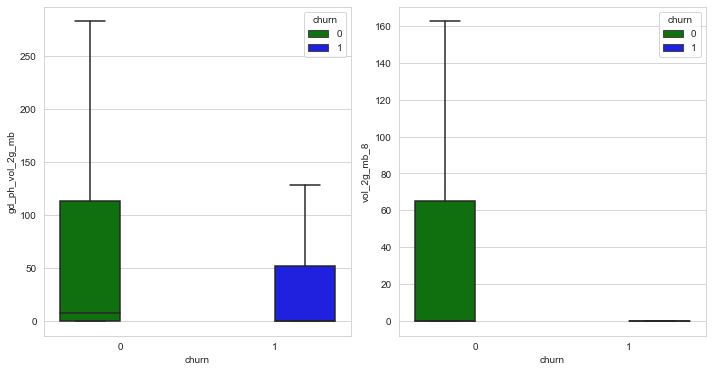

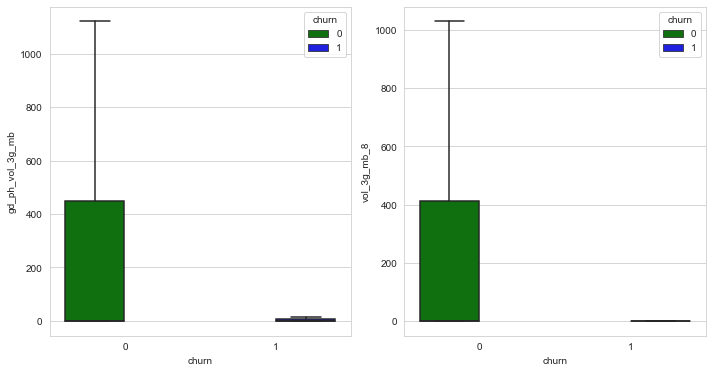

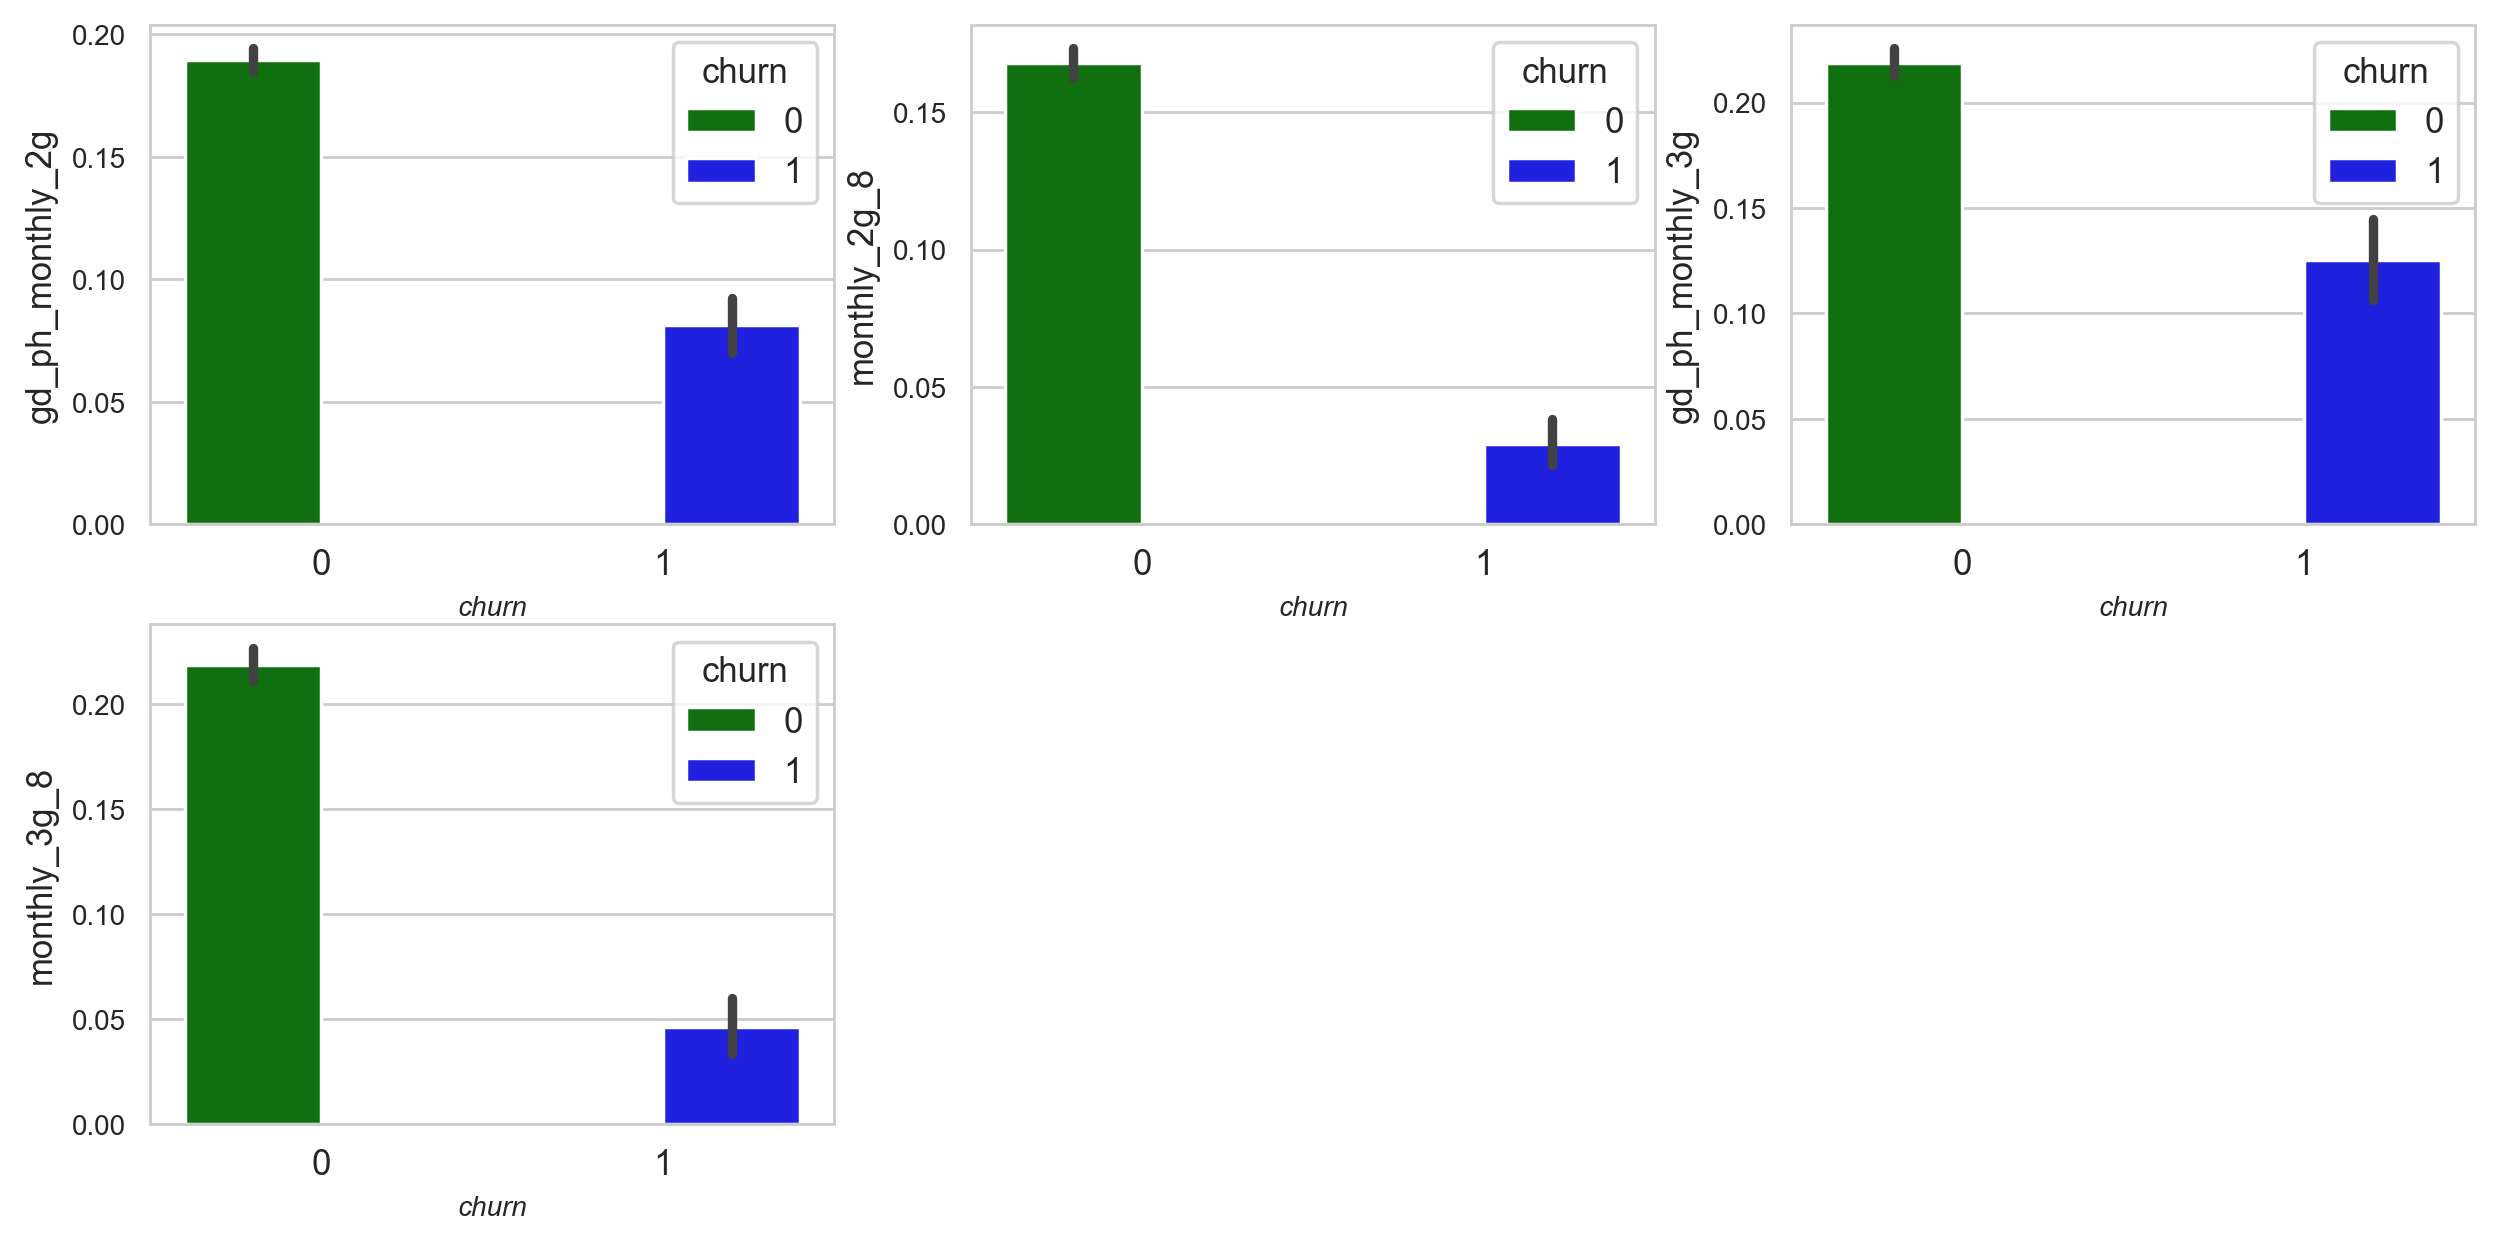

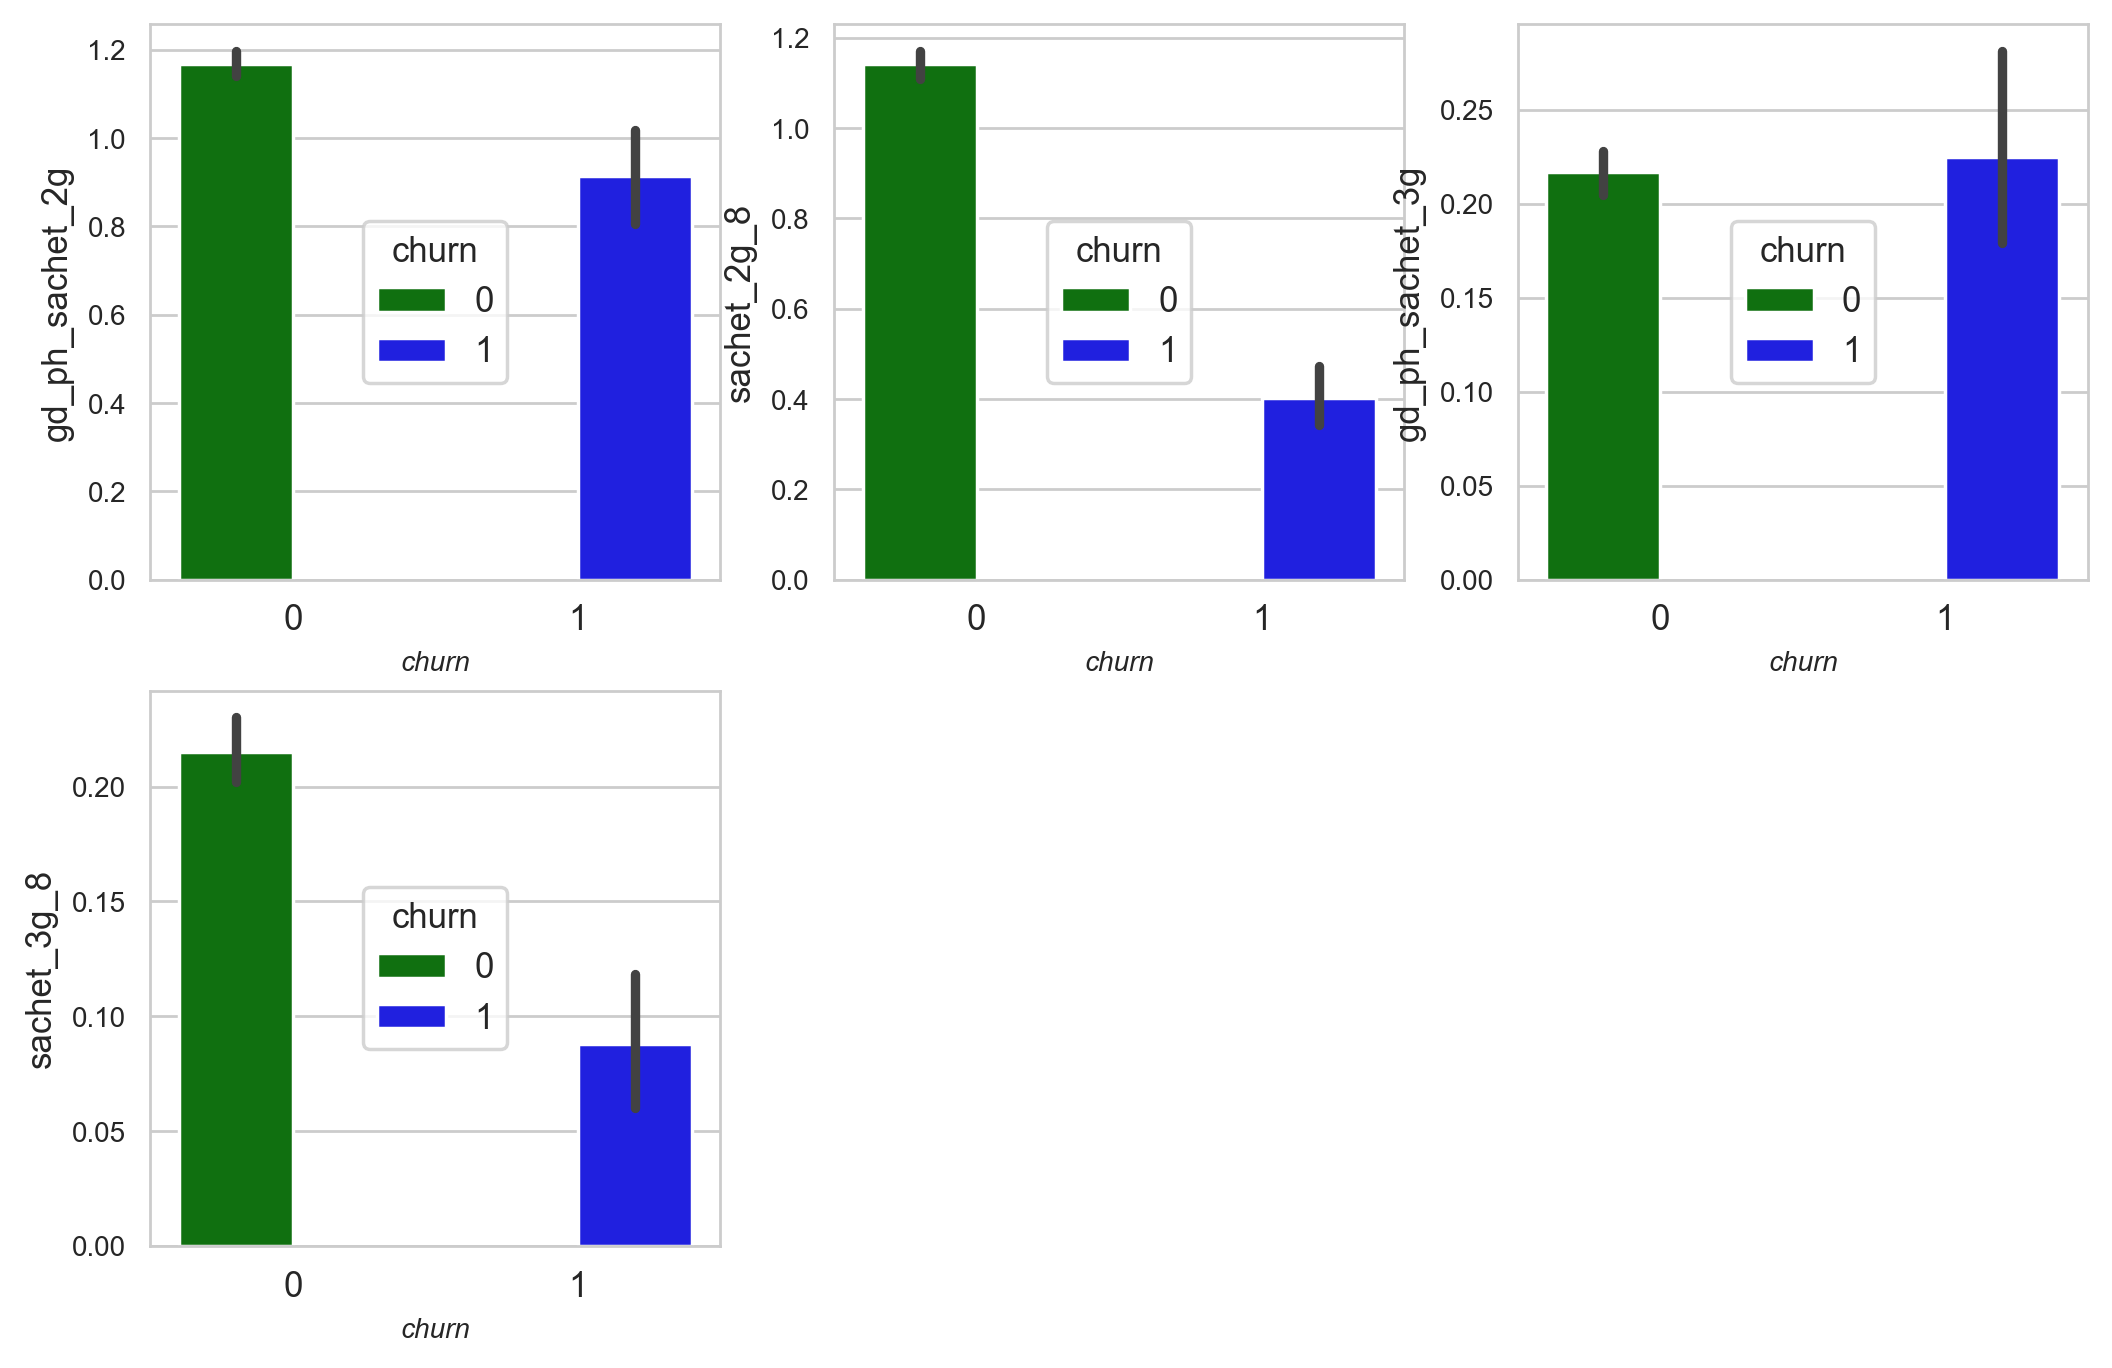

In [80]:
# Plotting boxplots for 'last_day_rech_amt' 
fig=plt.subplots(figsize=(10,10))

for i,feature in enumerate(["gd_ph_last_day_rech_amt", "last_day_rech_amt_8"]):
    plt.subplot(2, 2, i+1)
    plt.subplots_adjust(hspace = 4.0)
    sns.boxplot(y = feature, x = 'churn', data = tele_churn_data_1, hue="churn", showfliers= False, palette=['green','blue'])
    plt.tight_layout()

# Plotting volume of data usage: 
fig=plt.subplots(figsize=(10,10))

# Plotting volume of 2G data usage features:
for i,feature in enumerate(["gd_ph_vol_2g_mb", "vol_2g_mb_8"]):
    plt.subplot(2,2, i+1)
    plt.subplots_adjust(hspace = 4.0)
    sns.boxplot(y = feature, x = 'churn', data = tele_churn_data_1, hue="churn", showfliers= False, palette=['green','blue'])
    plt.tight_layout()

# Plotting volume of 3G data usage features  
fig=plt.subplots(figsize=(10,10))
for i,feature in enumerate(["gd_ph_vol_3g_mb", "vol_3g_mb_8"]):
    plt.subplot(2, 2, i+1)
    plt.subplots_adjust(hspace = 4.0)
    sns.boxplot(y = feature, x = 'churn', data = tele_churn_data_1, hue="churn", showfliers= False, palette=['green','blue'])
    plt.tight_layout()

# Barplots for 'monthly_2g' and 'monthly_3g' usage check
plt.figure(figsize=(12,9),dpi=250)
sns.set_style("whitegrid")
for i,feature in enumerate(["gd_ph_monthly_2g", "monthly_2g_8","gd_ph_monthly_3g", "monthly_3g_8"]):
    plt.subplot(3,3,i+1)
    ax=sns.barplot(data=tele_churn_data_1, y=feature ,x=tele_churn_data_1["churn"], hue="churn", palette=['green','blue'])
    ax.legend(loc='upper right', title="churn")
    plt.xlabel("churn", fontsize=8, fontstyle='italic')
    plt.yticks(fontsize=8)
plt.show()

# Schemes with validity smaller than a month for 2G (sachet_2g') and 3G('sachet_3g') features vizualization.
plt.figure(figsize=(10,10),dpi=250)
sns.set_style("whitegrid")
for i,feature in enumerate(["gd_ph_sachet_2g", "sachet_2g_8","gd_ph_sachet_3g", "sachet_3g_8"]):
    plt.subplot(3,3,i+1)
    ax=sns.barplot(data=tele_churn_data_1, y=feature ,x=tele_churn_data_1["churn"], hue="churn", palette=['green','blue'])
    ax.legend(loc="center", title="churn")
    plt.xlabel("churn", fontsize=8, fontstyle='italic')
    plt.yticks(fontsize=8)
plt.show()

#### Observation: 
1. Noticeable drop in the last day recharge amount in the 8th month (action phase) for churned customers.
2. Drop in volume of 2G and 3G data usage substantiallyin the 8th month i.e action phase for churned customers.
3. Usage of 3G data is comparatively lesser than that of 2G data, though the drop seems to follow similar pattern. 
4. Drop in monthly 2G and 3G subscriptions for churned customers in 8th Month i.e action phase.                                                                                                               
5. 'sachet_2g' and 'sachet_3g' schemes we largely used in the good phase( 6th and 7th months) and then the trend shows a sudden drop in the usage as we approach the 8th month i.e action phase for churned customers.

[Text(0.5, 0, 'Avg. Revenue Per User in Action phase ')]

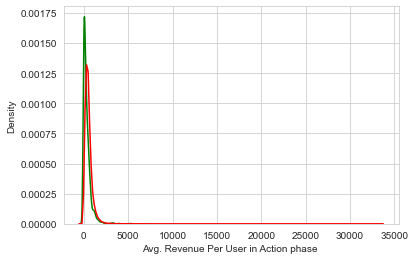

In [81]:
# Analysis of the average revenue per customer(ARPU) (churn and not churn) in the action phase:
# Creating churn dataframe
df_churn = tele_churn_data_1[tele_churn_data_1['churn'] == 1]
# Creating not churn dataframe
df_non_churn = tele_churn_data_1[tele_churn_data_1['churn'] == 0]

# Distribution plot
ax = sns.distplot(df_churn['arpu_8'],label='churn',color='green',hist=False)
ax = sns.distplot(df_non_churn['arpu_8'],label='not churn',color='red',hist=False)
ax.set(xlabel='Avg. Revenue Per User in Action phase ')

#### Observation: 
ARPU for the churned customers is mostly densed on lower range than ARPU for the not churned customers.
The higher ARPU customers are less likely to be churned.


### Bivariant Analysis:
Analysis of churn rate by the decreasing recharge amount and number of recharge in the action phase

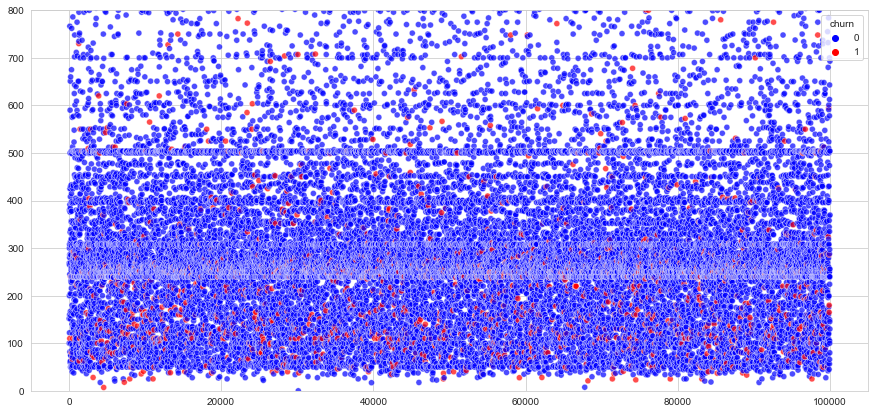

In [82]:
# Cheking Maximum recharge amount:

plt.figure(figsize=(15,7))

sns.scatterplot(x=tele_churn_data_1.index, y=tele_churn_data_1['gd_ph_max_rech_amt'] + tele_churn_data_1['max_rech_amt_8'],
                hue=tele_churn_data_1['churn'], alpha=0.7,palette=['blue','red'])
plt.ylim(0,800)
plt.show()

#### Observation: 
Users who had the max recharge amount less than 200 churned more.


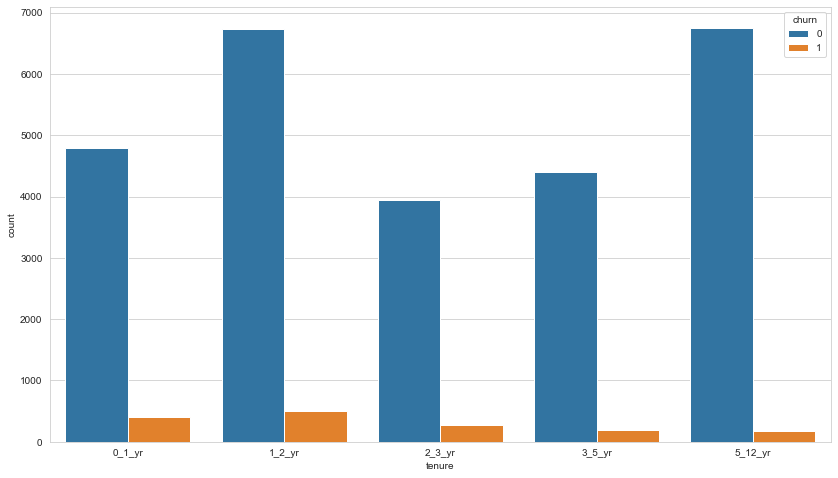

In [83]:
##Visualizing 'age of network' and 'churn'
plt.figure(figsize=(14,8))
tenure_data=tele_churn_data_1[['tenure','churn']]
sns.countplot(x = 'tenure', hue = 'churn',data = tenure_data,palette=("tab10"))
plt.show()

#### Observation:
We see that as the number of years on network (i.e AON) increases, the number of people churned out             (i.e. churn: 1) are reduced.

In [84]:
# Dropping few derived columns, which are not required in further analysis
tele_churn_data_1 = tele_churn_data_1.drop(['diff_rech_num','decrease_rech_num_actionphase','jun_vbc_3g','jul_vbc_3g', 'diff_vbc','decrease_vbc_actionphase'], axis=1)
tele_churn_data_1.shape

(28163, 84)

In [85]:
##Creating an alternate copy of 'tele_churn_data_1' dataframe 
tele_churn_data_2= tele_churn_data_1.copy()
##Rewriting original dataframe 'tele_churn_data_1
tele_churn_data_1 = tele_churn_data_2.copy()

#'tenure' is a categorical variable. Converting it into numeric using get_dummies
# Creating dummies for categorical variable 'tenure'
cat_cols= ['tenure']
tenure_data = pd.get_dummies(tele_churn_data_1['tenure'], prefix='tenure', drop_first = True)
tele_churn_data_1 = pd.concat([tele_churn_data_1, tenure_data], axis = 1)

In [86]:
##Dropping the 'tenure' column
tele_churn_data_1.drop(cat_cols, axis=1, inplace=True)
tele_churn_data_1.head()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,total_og_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,loc_ic_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,std_ic_mou_8,total_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rech_amt_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aug_vbc_3g,churn,gd_ph_std_og_t2t_mou,gd_ph_std_ic_mou,gd_ph_last_day_rech_amt,gd_ph_monthly_3g,gd_ph_sachet_3g,gd_ph_max_rech_amt,gd_ph_roam_ic_mou,gd_ph_spl_og_mou,gd_ph_vol_3g_mb,gd_ph_std_og_t2f_mou,gd_ph_offnet_mou,gd_ph_total_ic_mou,gd_ph_loc_ic_t2t_mou,gd_ph_loc_ic_t2m_mou,gd_ph_std_og_t2m_mou,gd_ph_sachet_2g,gd_ph_loc_og_mou,gd_ph_std_ic_t2m_mou,gd_ph_monthly_2g,gd_ph_loc_ic_t2f_mou,gd_ph_vol_2g_mb,gd_ph_isd_og_mou,gd_ph_loc_og_t2m_mou,gd_ph_ic_others,gd_ph_og_others,gd_ph_loc_ic_mou,gd_ph_loc_og_t2f_mou,gd_ph_total_rech_amt,gd_ph_std_ic_t2f_mou,gd_ph_isd_ic_mou,gd_ph_loc_og_t2c_mou,gd_ph_loc_og_t2t_mou,gd_ph_total_rech_num,gd_ph_std_ic_t2t_mou,gd_ph_onnet_mou,gd_ph_arpu,gd_ph_roam_og_mou,gd_ph_spl_ic_mou,gd_ph_total_og_mou,gd_ph_std_og_mou,gd_ph_vbc_3g,tenure_1_2_yr,tenure_2_3_yr,tenure_3_5_yr,tenure_5_12_yr
7,3171.480,52.29,325.91,31.64,38.06,40.28,162.28,53.23,0.00,255.79,12.01,49.14,16.68,77.84,10.01,6.50,0.0,350.16,27.31,121.19,39.53,188.04,30.39,141.33,22.21,193.94,428.74,0.0,31.59,15.14,7,3638,1580,779,0.00,0.00,0,0,0,0,57.74,1,13.795,176.810,0.0,0.0,0.0,1185.0,24.86,2.25,0.000,13.37,510.295,592.250,45.200,219.525,40.825,0.0,478.035,109.215,0.0,126.810,0.000,0.090,378.005,15.465,0.0,391.555,58.635,1185.0,43.215,8.295,0.0,41.385,5.0,24.360,56.26,1209.5150,18.165,0.105,548.385,68.000,19.060,0,1,0,0
8,137.362,35.08,136.48,0.00,0.00,12.49,50.54,0.00,7.15,63.04,22.58,75.69,0.00,98.28,0.00,10.23,0.0,171.56,0.31,15.48,0.00,15.79,0.10,0.65,0.00,0.75,16.54,0.0,0.00,0.00,14,120,30,10,0.03,11.94,0,3,0,0,21.03,0,124.995,13.545,25.0,0.0,0.0,122.0,0.00,0.00,375.475,0.00,87.645,66.175,16.840,35.780,11.865,0.5,333.135,13.255,0.5,0.000,178.000,0.000,75.770,0.000,0.0,52.630,0.000,519.0,0.000,0.000,0.0,257.360,20.0,0.290,382.36,435.4720,0.000,0.000,470.010,136.870,516.405,0,0,0,0
21,637.760,85.14,983.39,0.00,0.00,23.34,104.81,1.58,0.00,129.74,61.79,876.99,0.00,938.79,0.00,0.00,0.0,1068.54,19.54,129.16,10.39,159.11,0.18,101.74,0.00,101.93,261.04,0.0,0.00,0.00,27,718,50,50,0.00,0.00,0,0,0,0,0.00,0,111.935,62.985,25.0,0.0,0.0,50.0,0.00,0.00,0.000,0.00,827.305,169.490,6.335,96.430,737.050,0.0,95.565,52.960,0.0,3.725,0.000,0.000,89.870,0.000,0.0,106.505,0.375,640.0,0.000,0.000,0.0,5.320,24.0,10.020,117.26,556.1030,0.000,0.000,944.565,848.990,0.000,1,0,0,0
23,366.966,33.58,205.89,0.00,0.00,33.58,148.56,0.00,17.71,182.14,0.00,39.61,0.00,39.61,0.00,17.71,0.0,239.48,76.64,146.84,0.71,224.21,13.38,43.91,0.00,57.29,298.33,0.0,3.74,13.06,4,439,179,0,0.01,1009.92,0,0,1,1,40.45,0,0.000,8.915,89.5,1.0,0.0,89.5,0.00,0.05,299.545,0.00,87.385,171.235,40.875,104.635,4.355,0.0,132.795,8.660,0.0,0.000,0.240,0.005,82.975,2.675,0.0,145.520,0.000,227.0,0.000,14.115,0.0,49.810,4.0,0.255,49.81,134.1235,0.000,0.000,137.210,4.355,25.930,1,0,0,0
33,409.230,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.56,0.00,0.00,0.00,0.00,0.00,0.00,0.56,0.0,0.56,2.45,37.93,0.16,40.54,0.05,0.86,0.13,1.04,41.79,0.0,0.00,0.20,1,455,455,455,7.97,7701.01,0,0,1,0,358.10,0,0.000,4.420,126.0,4.5,2.0,753.5,0.00,0.00,5832.275,0.00,0.000,7.540,1.155,0.000,0.000,0.0,0.000,2.365,0.0,1.020,72.405,0.000,0.000,0.940,0.0,2.180,0.000,1932.0,0.595,0.000,0.0,0.000,10.5,1.455,0.00,1669.9265,0.000,0.000,0.000,0.000,2210.750,0,0,1,0


#### All the features are converted into numeric types.
#### Checking the Correlation between independent variables (multicollinearity)


In [87]:
## Eliminating those predictor variables that have a correlation of (threshold:-0.7 to 0.7) with other predictors.

corr_df = tele_churn_data_1.drop(['churn'],axis =1)
corr_matx = corr_df.corr().abs()
corr_matx

upper_triangle =corr_matx.where(np.triu(np.ones(corr_matx.shape), k=1).astype(np.bool))
col_to_drop = [col for col in upper_triangle.columns if any(upper_triangle[col] > 0.70)]

#Reduces multicollinearity (if any)
col_to_drop  #columns to drop from df. Independent predictors highly correlated to each other

##Dropping the strongly correlated variables 'cols_to_drop' from 'tele_churn_data_1' dataframe
tele_churn_data_1.drop(col_to_drop, axis=1, inplace= True)
tele_churn_data_1.shape

(28163, 49)

In [88]:
# Creating a function to find binary value columns from the 'tele_churn_data_1' dataframe.
def binary_value_cols(dataframe):
    dataframe_1 = dataframe.copy()
    binarycolumn = (dataframe_1.nunique()==2)
    list_binarycolumn = list(binarycolumn [binarycolumn .values==True].index)
    return list_binarycolumn

binary_cols_list =  binary_value_cols(dataframe= tele_churn_data_1)
print(binary_cols_list)

['churn', 'tenure_1_2_yr', 'tenure_2_3_yr', 'tenure_3_5_yr', 'tenure_5_12_yr']


### Test-Train Split and Feature scaling


In [89]:
# divide data into train and test
##split into train and test
from sklearn.model_selection import train_test_split
np.random.seed(0)
df_train, df_test = train_test_split(tele_churn_data_1, train_size=0.7, test_size = 0.3, random_state=42)

# Dataframe with binary columns
df_binary_train = df_train.loc[:, binary_cols_list]
df_binary_test =df_test.loc[:, binary_cols_list]

##Dropping binary dummy variables and we shall concat them later to preserve the scale
df_train = df_train.drop( binary_cols_list, axis=1)
df_test = df_test.drop( binary_cols_list, axis=1)

##StandardScaler
from sklearn.preprocessing import StandardScaler
all_colms = df_train.columns
scaler = StandardScaler()

#scaler fit_transform on train data
df_train[all_colms] = scaler.fit_transform(df_train[all_colms])
#concat dummies:Train set
df_train = pd.concat([df_train, df_binary_train], axis=1)

#scaler transform on test data
df_test[all_colms] = scaler.transform(df_test[all_colms])
#concat dummies: Test set
df_test = pd.concat([df_test, df_binary_test], axis=1)

print(df_train.shape)
print(df_test.shape)

(19714, 49)
(8449, 49)


In [90]:
##Storing target variable to y_train and y_test respectively
y_train = df_train['churn'].reset_index(drop=True)
y_test = df_test['churn'].reset_index(drop=True)

##Storing all feature variables to X_train and X_test
X_train = df_train.drop('churn',axis=1).reset_index(drop=True)
X_test = df_test.drop('churn',axis=1).reset_index(drop=True)

##Dealing with class imbalance 
y= tele_churn_data_2['churn']
print("Before Reampling, counts of label '1'(train_set): {}".format(sum(y_train==1)))
print("Before Resampling, counts of label '0'(train_set): {} \n".format(sum(y_train==0)))
print("Before Resampling, churn event rate (Entire Dataset): {}% \n".format(round(sum(y==1)/len(y)*100,3)))

Before Reampling, counts of label '1'(train_set): 1104
Before Resampling, counts of label '0'(train_set): 18610 

Before Resampling, churn event rate (Entire Dataset): 5.461% 



#### We have almost 5.46%  churn rate.

In [91]:
# let's build the logistic regression base model and check for stats (on unbalanced class dataset)

from sklearn.metrics import classification_report
from collections import Counter
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

# logistic regression object 
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression() 
  
# train the model on train set 
lr.fit(X_train, y_train.ravel()) 
predictions_train = lr.predict(X_train)

  
# predictions and print classification report  for test data
y_pred = lr.predict(X_test)


print ('Accuracy: ', accuracy_score(y_test, y_pred))
print ('F1 score: ', f1_score(y_test, y_pred))
print ('Recall: ', recall_score(y_test, y_pred))
print ('Precision: ', precision_score(y_test, y_pred))
print ('\n clasification report:\n', classification_report(y_test,y_pred))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred))

Accuracy:  0.9479228311042727
F1 score:  0.039301310043668124
Recall:  0.020737327188940093
Precision:  0.375

 clasification report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      8015
           1       0.38      0.02      0.04       434

    accuracy                           0.95      8449
   macro avg       0.66      0.51      0.51      8449
weighted avg       0.92      0.95      0.93      8449


 confussion matrix:
 [[8000   15]
 [ 425    9]]


Observations:             
(i) The accuracy is around 95 % but it doesn't conludes as a good evaluation metric as the classes are imbalanced in the dataset.    

(ii)  The recall of Churned (Sensitivity) is 0.02 is low and the recall of Not Churned i.e.(Specificity) is high, 1.00.   

(iii) This is not desired since we need to reduce the False Negatives.   
(iv)  For better prediction of Churned, the sensitivity has to be high and Specificity (recall for Not Churned) has to be low.   
(v)   In this problem we will use recall as evaluation metric because we would like to capture the performace where we will be rightly predicting positive classes.

### Handling Imbalanced Dataset
We can do that by following few techniques
1. Random Under-Sampling
2. Random Over-Sampling
3. SMOTE - Synthetic Minority Oversampling Technique
4. ADASYN - Adaptive Synthetic Sampling Method
5. SMOTETomek - Over-sampling followed by under-sampling
6. Tomek Links

In [92]:
##SMOTETomek' (SMOTE and Tomek links hybrid technique) to deal with the class imbalance

from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_resampled_smt_tmk, y_resampled_smt_tmk= smote_tomek.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled_smt_tmk).items()))

lreg_smt_tmk = LogisticRegression()
lreg_smt_tmk.fit(X_resampled_smt_tmk, y_resampled_smt_tmk)

y_pred_smt_tmk = lreg_smt_tmk.predict(X_test)

print ('Accuracy: ', accuracy_score(y_test, y_pred_smt_tmk))
print ('F1 score: ', f1_score(y_test, y_pred_smt_tmk))
print ('Recall: ', recall_score(y_test, y_pred_smt_tmk))
print ('Precision: ', precision_score(y_test, y_pred_smt_tmk))
print ('\n clasification report:\n', classification_report(y_test,y_pred_smt_tmk))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_smt_tmk))

print ('\n*****************Random_Undersampling*************\n')
# Random Undersampling
from imblearn.under_sampling import RandomUnderSampler
under_sample = RandomUnderSampler(random_state = 5)
X_resampled_us, y_resampled_us = under_sample.fit_resample(X_train, y_train)
len(X_resampled_us)
print(sorted(Counter(y_resampled_us).items()))

lreg_us = LogisticRegression()
lreg_us.fit(X_resampled_us, y_resampled_us)

y_pred_us = lreg_us.predict(X_test)

print ('Accuracy: ', accuracy_score(y_test, y_pred_us))
print ('F1 score: ', f1_score(y_test, y_pred_us))
print ('Recall: ', recall_score(y_test, y_pred_us))
print ('Precision: ', precision_score(y_test, y_pred_us))
print ('\n clasification report:\n', classification_report(y_test,y_pred_us))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_us))

print ('\n ******** Tomek*******\n')
# Tomek Links
from imblearn.under_sampling import TomekLinks
tomek_sample = TomekLinks(sampling_strategy='majority')
X_resampled_tomek, y_resampled_tomek = tomek_sample.fit_resample(X_train, y_train)
len(X_resampled_tomek)
print(sorted(Counter(y_resampled_tomek).items()))

lreg_tomek = LogisticRegression()
lreg_tomek.fit(X_resampled_tomek, y_resampled_tomek)

y_pred_tomek = lreg_tomek.predict(X_test)

print ('Accuracy: ', accuracy_score(y_test, y_pred_tomek))
print ('F1 score: ', f1_score(y_test, y_pred_tomek))
print ('Recall: ', recall_score(y_test, y_pred_tomek))
print ('Precision: ', precision_score(y_test, y_pred_tomek))
print ('\n clasification report:\n', classification_report(y_test,y_pred_tomek))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_tomek))

print ('\n ********Random Oversampling*******\n')
# Random OverSampling
from imblearn.over_sampling import RandomOverSampler
over_sample = RandomOverSampler(sampling_strategy = 1)
X_resampled_os, y_resampled_os = over_sample.fit_resample(X_train, y_train)
len(X_resampled_os)
print(sorted(Counter(y_resampled_os).items()))

lreg_os = LogisticRegression()
lreg_os.fit(X_resampled_os, y_resampled_os)

y_pred_os = lreg_os.predict(X_test)

print ('Accuracy: ', accuracy_score(y_test, y_pred_os))
print ('F1 score: ', f1_score(y_test, y_pred_os))
print ('Recall: ', recall_score(y_test, y_pred_os))
print ('Precision: ', precision_score(y_test, y_pred_os))
print ('\n clasification report:\n', classification_report(y_test,y_pred_os))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_os))

print ('\n ********SMOTE*******\n')
from imblearn.over_sampling import SMOTE
smt = SMOTE(random_state=45, k_neighbors=5)
X_resampled_smt, y_resampled_smt = smt.fit_resample(X_train, y_train)
len(X_resampled_smt)

print(sorted(Counter(y_resampled_smt).items()))
lreg_smt = LogisticRegression()
lreg_smt.fit(X_resampled_smt, y_resampled_smt)

y_pred_smt = lreg_smt.predict(X_test)

print ('Accuracy: ', accuracy_score(y_test, y_pred_smt))
print ('F1 score: ', f1_score(y_test, y_pred_smt))
print ('Recall: ', recall_score(y_test, y_pred_smt))
print ('Precision: ', precision_score(y_test, y_pred_smt))
print ('\n clasification report:\n', classification_report(y_test,y_pred_smt))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_smt))

print ('\n ********ADASYN*******\n')
from imblearn.over_sampling import ADASYN
ada = ADASYN(random_state=45, n_neighbors=5)
X_resampled_ada, y_resampled_ada = ada.fit_resample(X_train, y_train)
len(X_resampled_ada)
lreg_ada = LogisticRegression()
lreg_ada.fit(X_resampled_ada, y_resampled_ada)

y_pred_ada = lreg_ada.predict(X_test)

print ('Accuracy: ', accuracy_score(y_test, y_pred_ada))
print ('F1 score: ', f1_score(y_test, y_pred_ada))
print ('Recall: ', recall_score(y_test, y_pred_ada))
print ('Precision: ', precision_score(y_test, y_pred_ada))
print ('\n clasification report:\n', classification_report(y_test,y_pred_ada))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_ada))

[(0, 18604), (1, 18604)]
Accuracy:  0.8060125458634158
F1 score:  0.2814555019728189
Recall:  0.7396313364055299
Precision:  0.17379534380075798

 clasification report:
               precision    recall  f1-score   support

           0       0.98      0.81      0.89      8015
           1       0.17      0.74      0.28       434

    accuracy                           0.81      8449
   macro avg       0.58      0.77      0.58      8449
weighted avg       0.94      0.81      0.86      8449


 confussion matrix:
 [[6489 1526]
 [ 113  321]]

*****************Random_Undersampling*************

[(0, 1104), (1, 1104)]
Accuracy:  0.747189016451651
F1 score:  0.25210084033613445
Recall:  0.8294930875576036
Precision:  0.1486374896779521

 clasification report:
               precision    recall  f1-score   support

           0       0.99      0.74      0.85      8015
           1       0.15      0.83      0.25       434

    accuracy                           0.75      8449
   macro avg    

### Using Decision Trees


In [93]:
from sklearn.model_selection import train_test_split
np.random.seed(0)
df_train, df_test = train_test_split(tele_churn_data_1, train_size=0.7, test_size = 0.3, random_state=42)

# Dataframe with binary columns
df_binary_train = df_train.loc[:, binary_cols_list]
df_binary_test =df_test.loc[:, binary_cols_list]

##Dropping binary dummy variables and we shall concat them later to preserve the scale
df_train = df_train.drop( binary_cols_list, axis=1)
df_test = df_test.drop( binary_cols_list, axis=1)

##StandardScaler
from sklearn.preprocessing import StandardScaler
all_colms = df_train.columns
scaler = StandardScaler()

#scaler fit_transform on train data
df_train[all_colms] = scaler.fit_transform(df_train[all_colms])
#concat dummies:Train set
df_train = pd.concat([df_train, df_binary_train], axis=1)

#scaler transform on test data
df_test[all_colms] = scaler.transform(df_test[all_colms])
#concat dummies: Test set
df_test = pd.concat([df_test, df_binary_test], axis=1)

print(df_train.shape)
print(df_test.shape)


(19714, 49)
(8449, 49)


In [94]:
##Storing target variable to y_train and y_test respectively
y_train = df_train['churn'].reset_index(drop=True)
y_test = df_test['churn'].reset_index(drop=True)

##Storing all feature variables to X_train and X_test
X_train = df_train.drop('churn',axis=1).reset_index(drop=True)
X_test = df_test.drop('churn',axis=1).reset_index(drop=True)


In [95]:
# Decision Trees - Base
from sklearn.tree import DecisionTreeClassifier
dt_base = DecisionTreeClassifier(random_state=42, max_depth=4)
dt_base.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

##### In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook.
On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.

In [96]:
y_pred_rf = dt_base.predict(X_test)

from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

print ('Accuracy: ', accuracy_score(y_test, y_pred_rf))
print ('F1 score: ', f1_score(y_test, y_pred_rf))
print ('Recall: ', recall_score(y_test, y_pred_rf))
print ('Precision: ', precision_score(y_test, y_pred_rf))
print ('\n clasification report:\n', classification_report(y_test,y_pred_rf))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_rf))

Accuracy:  0.9526571191857024
F1 score:  0.4082840236686391
Recall:  0.31797235023041476
Precision:  0.5702479338842975

 clasification report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      8015
           1       0.57      0.32      0.41       434

    accuracy                           0.95      8449
   macro avg       0.77      0.65      0.69      8449
weighted avg       0.94      0.95      0.95      8449


 confussion matrix:
 [[7911  104]
 [ 296  138]]


In [97]:
print ('\n ********SMOTE+TOMEK*******\n')
from sklearn.tree import DecisionTreeClassifier
dtc_smt_tmk = DecisionTreeClassifier(random_state=0)
dtc_smt_tmk.fit(X_resampled_smt_tmk, y_resampled_smt_tmk)

y_pred_dtc_smt_tmk = dtc_smt_tmk.predict(X_test)

print ('Accuracy: ', accuracy_score(y_test, y_pred_dtc_smt_tmk))
print ('F1 score: ', f1_score(y_test, y_pred_dtc_smt_tmk))
print ('Recall: ', recall_score(y_test, y_pred_dtc_smt_tmk))
print ('Precision: ', precision_score(y_test, y_pred_dtc_smt_tmk))
print ('\n clasification report:\n', classification_report(y_test,y_pred_dtc_smt_tmk))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_dtc_smt_tmk))

print ('\n ********ADASYN*******\n')
from imblearn.over_sampling import ADASYN
ada = ADASYN(random_state=45, n_neighbors=5)
X_resampled_ada, y_resampled_ada = ada.fit_resample(X_train, y_train)
len(X_resampled_ada)

# Decision Trees - ADASYN
from sklearn.tree import DecisionTreeClassifier
dtc_ada = DecisionTreeClassifier(random_state=0)
dtc_ada.fit(X_resampled_ada, y_resampled_ada)

y_pred_dtc_ada = dtc_ada.predict(X_test)

print ('Accuracy: ', accuracy_score(y_test, y_pred_dtc_ada))
print ('F1 score: ', f1_score(y_test, y_pred_dtc_ada))
print ('Recall: ', recall_score(y_test, y_pred_dtc_ada))
print ('Precision: ', precision_score(y_test, y_pred_dtc_ada))
print ('\n clasification report:\n', classification_report(y_test,y_pred_dtc_ada))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_dtc_ada))

print ('\n ********Random Undersampling*******\n')
from imblearn.under_sampling import RandomUnderSampler
under_sample = RandomUnderSampler(random_state = 5)
X_resampled_us, y_resampled_us = under_sample.fit_resample(X_train, y_train)
len(X_resampled_us)

# Decision Trees - Random UnderSampling
from sklearn.tree import DecisionTreeClassifier
dtc_us = DecisionTreeClassifier(random_state=0)
dtc_us.fit(X_resampled_us, y_resampled_us)

y_pred_dtc_us = dtc_us.predict(X_test)

print ('Accuracy: ', accuracy_score(y_test, y_pred_dtc_us))
print ('F1 score: ', f1_score(y_test, y_pred_dtc_us))
print ('Recall: ', recall_score(y_test, y_pred_dtc_us))
print ('Precision: ', precision_score(y_test, y_pred_dtc_us))
print ('\n clasification report:\n', classification_report(y_test,y_pred_dtc_us))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_dtc_us))

print ('\n *******Tomek********\n')
from imblearn.under_sampling import TomekLinks
tomek_sample = TomekLinks(sampling_strategy='majority')
X_resampled_tomek, y_resampled_tomek = tomek_sample.fit_resample(X_train, y_train)
len(X_resampled_tomek)

from sklearn.tree import DecisionTreeClassifier
dtc_tomek = DecisionTreeClassifier(random_state=0)
dtc_tomek.fit(X_resampled_tomek, y_resampled_tomek)

y_pred_dtc_tomek = dtc_tomek.predict(X_test)

print ('Accuracy: ', accuracy_score(y_test, y_pred_dtc_tomek))
print ('F1 score: ', f1_score(y_test, y_pred_dtc_tomek))
print ('Recall: ', recall_score(y_test, y_pred_dtc_tomek))
print ('Precision: ', precision_score(y_test, y_pred_dtc_tomek))
print ('\n clasification report:\n', classification_report(y_test,y_pred_dtc_tomek))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_dtc_tomek))


print ('\n ******* Random OverSampling********\n')
from imblearn.over_sampling import RandomOverSampler
over_sample = RandomOverSampler(sampling_strategy = 1)
X_resampled_os, y_resampled_os = over_sample.fit_resample(X_train, y_train)
len(X_resampled_os)

from sklearn.tree import DecisionTreeClassifier
dtc_os = DecisionTreeClassifier(random_state=0)
dtc_os.fit(X_resampled_os, y_resampled_os)

y_pred_dtc_os = dtc_os.predict(X_test)

print ('Accuracy: ', accuracy_score(y_test, y_pred_dtc_os))
print ('F1 score: ', f1_score(y_test, y_pred_dtc_os))
print ('Recall: ', recall_score(y_test, y_pred_dtc_os))
print ('Precision: ', precision_score(y_test, y_pred_dtc_os))
print ('\n clasification report:\n', classification_report(y_test,y_pred_dtc_os))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_dtc_os))

print ('\n ******* SMOTE********\n')
from imblearn.over_sampling import SMOTE
smt = SMOTE(random_state=45, k_neighbors=5)
X_resampled_smt, y_resampled_smt = smt.fit_resample(X_train, y_train)
len(X_resampled_smt)

# Decision Trees - SMOTE
from sklearn.tree import DecisionTreeClassifier
dtc_smt = DecisionTreeClassifier(random_state=0)
dtc_smt.fit(X_resampled_smt, y_resampled_smt)

y_pred_dtc_smt = dtc_smt.predict(X_test)

print ('Accuracy: ', accuracy_score(y_test, y_pred_dtc_smt))
print ('F1 score: ', f1_score(y_test, y_pred_dtc_smt))
print ('Recall: ', recall_score(y_test, y_pred_dtc_smt))
print ('Precision: ', precision_score(y_test, y_pred_dtc_smt))
print ('\n clasification report:\n', classification_report(y_test,y_pred_dtc_smt))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_dtc_smt))



 ********SMOTE+TOMEK*******

Accuracy:  0.8892176588945437
F1 score:  0.3076923076923077
Recall:  0.4792626728110599
Precision:  0.22657952069716775

 clasification report:
               precision    recall  f1-score   support

           0       0.97      0.91      0.94      8015
           1       0.23      0.48      0.31       434

    accuracy                           0.89      8449
   macro avg       0.60      0.70      0.62      8449
weighted avg       0.93      0.89      0.91      8449


 confussion matrix:
 [[7305  710]
 [ 226  208]]

 ********ADASYN*******

Accuracy:  0.8838915848029353
F1 score:  0.28758169934640526
Recall:  0.45622119815668205
Precision:  0.20996818663838812

 clasification report:
               precision    recall  f1-score   support

           0       0.97      0.91      0.94      8015
           1       0.21      0.46      0.29       434

    accuracy                           0.88      8449
   macro avg       0.59      0.68      0.61      8449
weigh

### Using Random Forest

In [98]:
# Random Forest - Base
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print ('Accuracy: ', accuracy_score(y_test, y_pred_rf))
print ('F1 score: ', f1_score(y_test, y_pred_rf))
print ('Recall: ', recall_score(y_test, y_pred_rf))
print ('Precision: ', precision_score(y_test, y_pred_rf))
print ('\n clasification report:\n', classification_report(y_test,y_pred_rf))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_rf))

Accuracy:  0.9540774056101313
F1 score:  0.3618421052631579
Recall:  0.2534562211981567
Precision:  0.632183908045977

 clasification report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      8015
           1       0.63      0.25      0.36       434

    accuracy                           0.95      8449
   macro avg       0.80      0.62      0.67      8449
weighted avg       0.94      0.95      0.94      8449


 confussion matrix:
 [[7951   64]
 [ 324  110]]


In [99]:
print ('\n ******* Random UnderSampling********\n')
rf_us = RandomForestClassifier()
rf_us.fit(X_resampled_us, y_resampled_us)

y_pred_rf_us = rf_us.predict(X_test)

print ('Accuracy: ', accuracy_score(y_test, y_pred_rf_us))
print ('F1 score: ', f1_score(y_test, y_pred_rf_us))
print ('Recall: ', recall_score(y_test, y_pred_rf_us))
print ('Precision: ', precision_score(y_test, y_pred_rf_us))
print ('\n clasification report:\n', classification_report(y_test,y_pred_rf_us))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_rf_us))

print ('\n *******Tomek********\n')
rf_tomek = RandomForestClassifier()
rf_tomek.fit(X_resampled_tomek, y_resampled_tomek)

y_pred_rf_tomek = rf_tomek.predict(X_test)

print ('Accuracy: ', accuracy_score(y_test, y_pred_rf_tomek))
print ('F1 score: ', f1_score(y_test, y_pred_rf_tomek))
print ('Recall: ', recall_score(y_test, y_pred_rf_tomek))
print ('Precision: ', precision_score(y_test, y_pred_rf_tomek))
print ('\n clasification report:\n', classification_report(y_test,y_pred_rf_tomek))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_rf_tomek))

print ('\n *******Random Over-Sampling********\n')
rf_os = RandomForestClassifier()
rf_os.fit(X_resampled_os, y_resampled_os)

y_pred_rf_os = rf_os.predict(X_test)

print ('Accuracy: ', accuracy_score(y_test, y_pred_rf_os))
print ('F1 score: ', f1_score(y_test, y_pred_rf_os))
print ('Recall: ', recall_score(y_test, y_pred_rf_os))
print ('Precision: ', precision_score(y_test, y_pred_rf_os))
print ('\n clasification report:\n', classification_report(y_test,y_pred_rf_os))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_rf_os))

print ('\n *******SMOTE********\n')
rf_smt = RandomForestClassifier()
rf_smt.fit(X_resampled_smt, y_resampled_smt)

y_pred_rf_smt = rf_smt.predict(X_test)

print ('Accuracy: ', accuracy_score(y_test, y_pred_rf_smt))
print ('F1 score: ', f1_score(y_test, y_pred_rf_smt))
print ('Recall: ', recall_score(y_test, y_pred_rf_smt))
print ('Precision: ', precision_score(y_test, y_pred_rf_smt))
print ('\n clasification report:\n', classification_report(y_test,y_pred_rf_smt))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_rf_smt))

print ('\n *******ADASYN********\n')
rf_ada = RandomForestClassifier()
rf_ada.fit(X_resampled_ada, y_resampled_ada)

y_pred_rf_ada = rf_ada.predict(X_test)

print ('Accuracy: ', accuracy_score(y_test, y_pred_rf_ada))
print ('F1 score: ', f1_score(y_test, y_pred_rf_ada))
print ('Recall: ', recall_score(y_test, y_pred_rf_ada))
print ('Precision: ', precision_score(y_test, y_pred_rf_ada))
print ('\n clasification report:\n', classification_report(y_test,y_pred_rf_ada))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_rf_ada))

print ('\n *******SMOTE+TOMEK********\n')

rf_smt_tmk = RandomForestClassifier()
rf_smt_tmk.fit(X_resampled_smt_tmk, y_resampled_smt_tmk)

y_pred_rf_smt_tmk = rf_smt_tmk.predict(X_test)

print ('Accuracy: ', accuracy_score(y_test, y_pred_rf_smt_tmk))
print ('F1 score: ', f1_score(y_test, y_pred_rf_smt_tmk))
print ('Recall: ', recall_score(y_test, y_pred_rf_smt_tmk))
print ('Precision: ', precision_score(y_test, y_pred_rf_smt_tmk))
print ('\n clasification report:\n', classification_report(y_test,y_pred_rf_smt_tmk))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred_rf_smt_tmk))



 ******* Random UnderSampling********

Accuracy:  0.8610486448100367
F1 score:  0.3715203426124197
Recall:  0.7995391705069125
Precision:  0.2419804741980474

 clasification report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92      8015
           1       0.24      0.80      0.37       434

    accuracy                           0.86      8449
   macro avg       0.61      0.83      0.65      8449
weighted avg       0.95      0.86      0.89      8449


 confussion matrix:
 [[6928 1087]
 [  87  347]]

 *******Tomek********

Accuracy:  0.9547875488223458
F1 score:  0.39171974522292996
Recall:  0.2834101382488479
Precision:  0.634020618556701

 clasification report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      8015
           1       0.63      0.28      0.39       434

    accuracy                           0.95      8449
   macro avg       0.80      0.64      0.68      8449


We can also notice that recall values of logistic regression for both under and oversamplings are closer to each other.

#### We will pick up 'Logistic Regression with Random oversampling' method.


In [100]:
##Implementing 'Random OverSampling' technique to deal with the class imbalance

from imblearn.over_sampling import RandomOverSampler
over_sample = RandomOverSampler(sampling_strategy = 1)
X_resampled_os, y_resampled_os = over_sample.fit_resample(X_train, y_train)

print('After Random overersampling, the shape of train_X: {}'.format(X_resampled_os.shape))
print('After Random overersampling, the shape of train_y: {} \n'.format(y_resampled_os.shape))

print("After Random overersampling, counts of label '1': {}".format(sum(y_resampled_os==1)))
print("After Random overersampling, counts of label '0': {}".format(sum(y_resampled_os==0)))
print("After Random overersampling, churn event rate : {}% \n".format(round(sum(y_resampled_os==1)/len(y_resampled_os)*100,2)))


After Random overersampling, the shape of train_X: (37220, 48)
After Random overersampling, the shape of train_y: (37220,) 

After Random overersampling, counts of label '1': 18610
After Random overersampling, counts of label '0': 18610
After Random overersampling, churn event rate : 50.0% 



### Model Building 

In [101]:
# Logistic regression model
import statsmodels.api as sm
lm_1 = sm.GLM(y_resampled_os,(sm.add_constant(X_resampled_os)), family = sm.families.Binomial())
lm_1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                37220
Model:                            GLM   Df Residuals:                    37171
Model Family:                Binomial   Df Model:                           48
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18538.
Date:                Tue, 25 Apr 2023   Deviance:                       37075.
Time:                        10:14:14   Pearson chi2:                 1.18e+07
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3231
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.8050      0.032    -25.198      0.000      -0.868      -0.742
arpu_8                      0.1550      0.039      4.014      0.000       0.079       0.231
onnet_mou_8                -0.1091      0.020     -5.470      0.000      -0.148      -0.070
offnet_mou_8               -0.1653      0.020     -8.146      0.000      -0.205      -0.126
roam_ic_mou_8               0.0239      0.015      1.587      0.113      -0.006       0.053
roam_og_mou_8               0.1975      0.021      9.400      0.000       0.156       0.239
loc_og_t2t_mou_8           -0.0943      0.026     -3.585      0.000      -0.146      -0.043
loc_og_t2m_mou_8           -0.2886      0.031     -9.431      0.000      -0.349      -0.229
loc_og_t2f_mou_8           -0.0818      0.025     -3.273      0.001      -0.131      -0.033
loc_og_t2c_mou_8            0.1774      0.023      7.662      0.000       0.132       0.223
std_og_t2f_mou_8           -0.0679      0.021     -3.313      0.001      -0.108      -0.028
isd_og_mou_8               -0.0120      0.026     -0.458      0.647      -0.063       0.039
spl_og_mou_8               -0.3143      0.032     -9.929      0.000      -0.376      -0.252
og_others_8                -0.0360      0.028     -1.300      0.194      -0.090       0.018
loc_ic_t2t_mou_8           -0.5180      0.043    -12.162      0.000      -0.601      -0.435
loc_ic_t2m_mou_8           -0.6338      0.036    -17.504      0.000      -0.705      -0.563
loc_ic_t2f_mou_8           -0.2981      0.035     -8.419      0.000      -0.368      -0.229
std_ic_t2t_mou_8           -0.1191      0.025     -4.746      0.000      -0.168      -0.070
std_ic_t2m_mou_8           -0.1604      0.022     -7.456      0.000      -0.203      -0.118
std_ic_t2f_mou_8           -0.0729      0.031     -2.325      0.020      -0.134      -0.011
spl_ic_mou_8               -0.1648      0.018     -8.979      0.000      -0.201      -0.129
isd_ic_mou_8               -0.1385      0.028     -5.013      0.000      -0.193      -0.084
ic_others_8                -0.0270      0.026     -1.027      0.305      -0.079       0.025
total_rech_num_8           -0.2041      0.019    -10.619      0.000      -0.242      -0.166
max_rech_amt_8              0.0982      0.024      4.174      0.000       0.052       0.144
last_day_rech_amt_8        -0.3862      0.022    -17.890      0.000      -0.428      -0.344
vol_2g_mb_8                -0.2644      0.027     -9.740      0.000      -0.318      -0.211
vol_3g_mb_8                -0.2584      0.042     -6.210      0.000      -0.340      -0.177
monthly_2g_8               -0.5093      0.027    -18.650      0.000      -0.563      -0.456
sachet_2g_8                -0.5246      0.022    -23.521      0.000      -0.568      -0.481
monthly_3g_8               -0.6600      0.037  

## Feature Selection Using RFE

In [102]:
logreg = LogisticRegression()  
logreg

from sklearn.feature_selection import RFE
rfe = RFE(logreg,step = 25)             # running RFE with 25 variables as output
rfe = rfe.fit(X_resampled_os, y_resampled_os)

list(zip(X_resampled_os.columns, rfe.support_, rfe.ranking_))

col = X_resampled_os.columns[rfe.support_]
X_resampled_os.columns[~rfe.support_]


Index(['arpu_8', 'onnet_mou_8', 'roam_ic_mou_8', 'loc_og_t2t_mou_8',
       'loc_og_t2f_mou_8', 'std_og_t2f_mou_8', 'isd_og_mou_8', 'og_others_8',
       'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8',
       'isd_ic_mou_8', 'ic_others_8', 'max_rech_amt_8', 'aug_vbc_3g',
       'gd_ph_last_day_rech_amt', 'gd_ph_monthly_3g', 'gd_ph_roam_ic_mou',
       'gd_ph_og_others', 'gd_ph_loc_og_t2c_mou', 'gd_ph_roam_og_mou',
       'gd_ph_spl_ic_mou', 'tenure_1_2_yr', 'tenure_2_3_yr'],
      dtype='object')

In [103]:
##Creating X_resampled_us_sm dataframe with RFE selected variables
X_resampled_os_sm = X_resampled_os[col]

X_resampled_os_sm = sm.add_constant(X_resampled_os[col])
lm_2 = sm.GLM(y_resampled_os,X_resampled_os_sm, family = sm.families.Binomial())
res = lm_2.fit()
res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                37220
Model:                            GLM   Df Residuals:                    37195
Model Family:                Binomial   Df Model:                           24
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18885.
Date:                Tue, 25 Apr 2023   Deviance:                       37771.
Time:                        10:14:15   Pearson chi2:                 4.35e+05
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3103
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.8034      0.022    -36.946      0.000      -0.846      -0.761
offnet_mou_8           -0.1261      0.017     -7.628      0.000      -0.159      -0.094
roam_og_mou_8           0.3720      0.016     23.123      0.000       0.341       0.404
loc_og_t2m_mou_8       -0.2589      0.029     -8.926      0.000      -0.316      -0.202
loc_og_t2c_mou_8        0.1254      0.020      6.336      0.000       0.087       0.164
spl_og_mou_8           -0.2704      0.029     -9.476      0.000      -0.326      -0.214
loc_ic_t2t_mou_8       -0.5588      0.040    -14.106      0.000      -0.636      -0.481
loc_ic_t2m_mou_8       -0.6132      0.035    -17.678      0.000      -0.681      -0.545
loc_ic_t2f_mou_8       -0.3387      0.034     -9.896      0.000      -0.406      -0.272
spl_ic_mou_8           -0.1444      0.018     -8.027      0.000      -0.180      -0.109
total_rech_num_8       -0.2647      0.017    -15.824      0.000      -0.297      -0.232
last_day_rech_amt_8    -0.2885      0.016    -17.958      0.000      -0.320      -0.257
vol_2g_mb_8            -0.2518      0.027     -9.427      0.000      -0.304      -0.199
vol_3g_mb_8            -0.1621      0.035     -4.621      0.000      -0.231      -0.093
monthly_2g_8           -0.4962      0.027    -18.554      0.000      -0.549      -0.444
sachet_2g_8            -0.5444      0.022    -24.682      0.000      -0.588      -0.501
monthly_3g_8           -0.5075      0.032    -15.753      0.000      -0.571      -0.444
sachet_3g_8            -0.2485      0.033     -7.472      0.000      -0.314      -0.183
gd_ph_sachet_3g         0.1673      0.020      8.484      0.000       0.129       0.206
gd_ph_spl_og_mou        0.1511      0.017      8.710      0.000       0.117       0.185
gd_ph_monthly_2g       -0.2103      0.021    -10.140      0.000      -0.251      -0.170
gd_ph_vol_2g_mb         0.2070      0.018     11.320      0.000       0.171       0.243
gd_ph_isd_ic_mou        0.1025      0.017      6.121      0.000       0.070       0.135
tenure_3_5_yr          -0.4485      0.036    -12.304      0.000      -0.520      -0.377
tenure_5_12_yr         -0.7100      0.037    -19.294      0.000      -0.782      -0.638
=======================================================================================
"""

In [104]:
##Getting the predicted values on the train set
y_resampled_os_pred = res.predict( X_resampled_os_sm).values.reshape(-1)
y_resampled_os_pred[:10]

y_resampled_os_final = pd.DataFrame({'Churn':y_resampled_os.values, 'Churn_Prob':y_resampled_os_pred})
y_resampled_os_final['CustID'] = y_resampled_os.index    ##CustID is the record index ID
y_resampled_os_final.head()

# Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0
y_resampled_os_final['predicted'] = y_resampled_os_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_resampled_os_final.head()

,Churn,Churn_Prob,CustID,predicted
0,0,0.589652,0,1
1,0,0.485363,1,0
2,0,0.080905,2,0
3,0,0.781465,3,1
4,0,0.218580,4,0


In [105]:
# Confusion matrix 
from sklearn import metrics
from sklearn.metrics import confusion_matrix
confusion = metrics.confusion_matrix(y_resampled_os_final.Churn, y_resampled_os_final.predicted )
confusion

# Let's check the overall accuracy.
from sklearn import metrics
print(metrics.accuracy_score(y_resampled_os_final.Churn, y_resampled_os_final.predicted))


0.7627619559376679


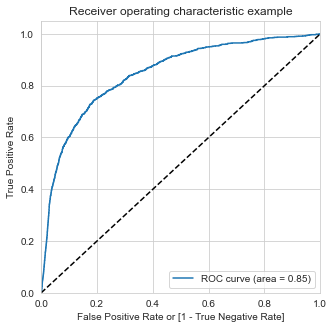

In [106]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False)
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

fpr, tpr, thresholds = metrics.roc_curve(y_resampled_os_final.Churn, y_resampled_os_final.Churn_Prob, drop_intermediate = False )

## ROC curve for train data

draw_roc( y_resampled_os_final.Churn,  y_resampled_os_final.Churn_Prob)

### Finding Optimal Cutoff Point
Optimal cutoff probability is that prob where we get balanced sensitivity and specificity

     prob  accuracy     sensi     speci
0.0   0.0  0.500000  1.000000  0.000000
0.1   0.1  0.602902  0.975175  0.230629
0.2   0.2  0.667894  0.953036  0.382751
0.3   0.3  0.712547  0.917356  0.507738
0.4   0.4  0.743015  0.868834  0.617195
0.5   0.5  0.762762  0.802794  0.722730
0.6   0.6  0.775336  0.728802  0.821870
0.7   0.7  0.745997  0.580978  0.911016
0.8   0.8  0.655132  0.339495  0.970768
0.9   0.9  0.523966  0.053627  0.994304


<Figure size 720x360 with 0 Axes>

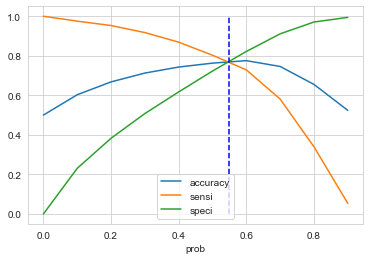

In [107]:
# Let's create columns with different probability cutoffs 
cut_numbers = [float(x)/10 for x in range(10)]
for i in cut_numbers:
    y_resampled_os_final[i]=y_resampled_os_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
y_resampled_os_final.head()


# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cut_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix( y_resampled_os_final.Churn, y_resampled_os_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cut_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cut_df)

# Let's plot accuracy sensitivity and specificity for various probabilities.
sns.set_style('whitegrid')
plt.figure(figsize=(10,5))
cut_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.vlines(x=0.55, ymax=1, ymin=0, colors="b", linestyles="--")
plt.show()

From the curve above, 0.55 is the optimum point to take it as a cutoff probability.

In [108]:
y_resampled_os_final['final_predicted'] =  y_resampled_os_final.Churn_Prob.map( lambda x: 1 if x > 0.55 else 0)
y_resampled_os_final.head()

##Confusion Matrix (optimal train set) 
confusion_train = metrics.confusion_matrix(y_resampled_os_final.Churn, y_resampled_os_final.final_predicted )
confusion_train

# Let's check the overall accuracy.
metrics.accuracy_score(y_resampled_os_final.Churn, y_resampled_os_final.final_predicted)

0.7709564750134337

In [109]:
def other_mtx_logit_model(confusion):
    
    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives
    
    sensitivity= round((TP) / (TP+FN),4) #sensitivity logistic regression model
    specificity= round((TN) / (TN+FP),4) #specificity logistic regression model   
    FPR= round((FP) / (TN+FP),4)        #False Positive Rate - predicting churn when customer does not have churned
    positive_pred_val= round((TP) / (TP+FP),4)  #Positive predictive value
    negative_pred_val= round((TN) / (TN+ FN),4) #Negative predictive value
        
    mtx_list= ['Sensitivity', 'Specificity', 'False Positive Rate','Positive Predictive Value','Negative Predictive Value']
    mtx_val = [sensitivity, specificity, FPR, positive_pred_val, negative_pred_val]
    eval_mtx_df=pd.DataFrame({'Evaluation Metrics':mtx_list, 'Value': mtx_val})
    eval_mtx_df.set_index('Evaluation Metrics', inplace= True)
    return eval_mtx_df

print('**Evaluation Metrics: Train Set (Optimal Cut-off)**')
print("******************************************************************")

print('Accuracy of Train Set: (Logistic Regression Model):')
print(metrics.accuracy_score(y_resampled_os_final.Churn, y_resampled_os_final.final_predicted))

print("******************************************************************")
print(classification_report(y_resampled_os_final.Churn, y_resampled_os_final.final_predicted, target_names=['Not Churned','Churned']))
print("******************************************************************")
print(other_mtx_logit_model(confusion_train))
print("******************************************************************")
print('ROC of Train Set: (Logistic Regression Model):')
print("{:2.3}".format(metrics.roc_auc_score(y_resampled_os_final.Churn, y_resampled_os_final.Churn_Prob)))

**Evaluation Metrics: Train Set (Optimal Cut-off)**
******************************************************************
Accuracy of Train Set: (Logistic Regression Model):
0.7709564750134337
******************************************************************
              precision    recall  f1-score   support

 Not Churned       0.77      0.77      0.77     18610
     Churned       0.77      0.77      0.77     18610

    accuracy                           0.77     37220
   macro avg       0.77      0.77      0.77     37220
weighted avg       0.77      0.77      0.77     37220

******************************************************************
                            Value
Evaluation Metrics               
Sensitivity                0.7690
Specificity                0.7729
False Positive Rate        0.2271
Positive Predictive Value  0.7720
Negative Predictive Value  0.7699
******************************************************************
ROC of Train Set: (Logistic Regression Model

#### Observation:
After finding optimal cut-off,    
(i) ROC_AUC of the train set: 0.847   
(ii) Recall Score of the train set: 0.77

### Precision and Recall Trade-off

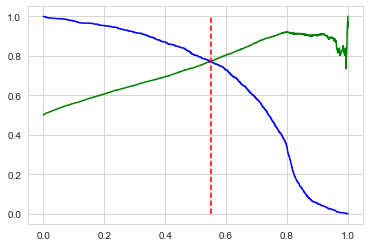

In [110]:
from sklearn.metrics import precision_recall_curve
sns.set_style('whitegrid')

p, r, thresholds = precision_recall_curve(y_resampled_os_final.Churn, y_resampled_os_final.Churn_Prob)

plt.plot(thresholds, p[:-1], "g-")    ##Precision: Green-Line
plt.plot(thresholds, r[:-1], "b-")   ##Recall: Red-Line
plt.vlines(x=0.55, ymax=1, ymin=0, colors='red', linestyles="--")
plt.show()

###  Making predictions and evaluation on the test set


In [111]:
##Making predictions on test data

X_resampled_os_sm_new =X_resampled_os_sm
X_resampled_os_sm_new.drop('const', axis=1, inplace=True)

#Assigning similar columns to test data as that of train set
X_test= X_test[X_resampled_os_sm_new.columns]
X_test.head()

##Adding the constant to X_test (as res model is based on statsmodels)
X_test_sm = sm.add_constant(X_test)
y_test_pred = res.predict(X_test_sm)

##Getting the predicted values on the test set
y_test_pred = res.predict(X_test_sm)
y_test_pred[:10]

y_test_pred = y_test_pred.values.reshape(-1)
y_test_pred[:10]


array([0.26918911, 0.69595103, 0.49996222, 0.11594244, 0.50954028,
       0.77999292, 0.54252591, 0.12249734, 0.4358429 , 0.07079431])

#### Creating a dataframe with the actual churn flag and the predicted probabilities


In [112]:
y_test_pred_final = pd.DataFrame({'Churn':y_test.values, 'Churn_Prob':y_test_pred})
y_test_pred_final['CustID'] = y_test.index    ##CustID is the record index ID
y_test_pred_final.head()


,Churn,Churn_Prob,CustID
0,0,0.269189,0
1,0,0.695951,1
2,0,0.499962,2
3,0,0.115942,3
4,0,0.509540,4


#### Creating new column 'predicted' with 1 if Churn_Prob > 0.55 (optimal cut-off) else 0

In [113]:
y_test_pred_final['predicted'] = y_test_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.55 else 0)  ##optimal cut-off is 0.55
y_test_pred_final.head()


,Churn,Churn_Prob,CustID,predicted
0,0,0.269189,0,0
1,0,0.695951,1,1
2,0,0.499962,2,0
3,0,0.115942,3,0
4,0,0.509540,4,0


In [114]:
##Confusion Matrix (optimal test set) 
confusion_test = metrics.confusion_matrix(y_test_pred_final.Churn, y_test_pred_final.predicted )
confusion_test

print('**Evaluation Metrics: Test Set (Optimal Cut-off)**')
print("******************************************************************")

print('Accuracy of Test Set: (Logistic Regression Model):')
print(metrics.accuracy_score(y_test_pred_final.Churn, y_test_pred_final.predicted))

print("******************************************************************")
print(classification_report(y_test_pred_final.Churn, y_test_pred_final.predicted, target_names=['Not Churned','Churned']))
print("******************************************************************")
print(other_mtx_logit_model(confusion_test))
print("******************************************************************")
print('ROC of Test Set: (Logistic Regression Model):')
print("{:2.3}".format(metrics.roc_auc_score(y_test_pred_final.Churn, y_test_pred_final.Churn_Prob)))


**Evaluation Metrics: Test Set (Optimal Cut-off)**
******************************************************************
Accuracy of Test Set: (Logistic Regression Model):
0.783287963072553
******************************************************************
              precision    recall  f1-score   support

 Not Churned       0.99      0.78      0.87      8015
     Churned       0.16      0.79      0.27       434

    accuracy                           0.78      8449
   macro avg       0.58      0.79      0.57      8449
weighted avg       0.94      0.78      0.84      8449

******************************************************************
                            Value
Evaluation Metrics               
Sensitivity                0.7926
Specificity                0.7828
False Positive Rate        0.2172
Positive Predictive Value  0.1650
Negative Predictive Value  0.9859
******************************************************************
ROC of Test Set: (Logistic Regression Model):
0

Observation:
Using the optimal cut-off,    
(i) ROC_AUC of test set: 0.859   
(ii) Recall Score of test set: 0.79

### Top 15 Features

In [115]:
res.params.sort_values(ascending=False)[0:15]

roam_og_mou_8       0.372041
gd_ph_vol_2g_mb     0.207024
gd_ph_sachet_3g     0.167342
gd_ph_spl_og_mou    0.151132
loc_og_t2c_mou_8    0.125373
gd_ph_isd_ic_mou    0.102507
offnet_mou_8       -0.126102
spl_ic_mou_8       -0.144392
vol_3g_mb_8        -0.162138
gd_ph_monthly_2g   -0.210329
sachet_3g_8        -0.248479
vol_2g_mb_8        -0.251777
loc_og_t2m_mou_8   -0.258946
total_rech_num_8   -0.264682
spl_og_mou_8       -0.270363
dtype: float64

#### Train set     
Accuracy =  0.77    
Sensitivity/Recall = 0.77     
Specificity = 0.77 
 

#### Test set      
Accuracy = 0.77   
Sensitivity/Recall= 0.78   
Specificity =  0.77 